In [14]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import os, sys
sys.path.append('/home/hrai/codes/hpe_library')
from lib_import import *
from my_utils import BatchCamera, Camera
from my_utils import arg_as_list, get_configs
from my_utils import generate_random_segment, generate_random_trajectory, get_aligned_init_torso, get_ap_pose_2d, get_backbone_line_from_torso, get_bounded_segments_idx, get_cam_param, get_input, get_label, get_model_input, get_output, get_pairs, get_part_traj, get_pose_seq_and_cam_param, get_two_point_parts, load_h36m, load_segment_file_from_parameters, make_input, make_one_dimension_list, make_output, split_continuous_indices, MyCustomDataset, parse_args_by_model_name, get_input_gt_for_onevec, get_limb_angle, get_h36m_camera_info, h36m_data_processing
from my_utils import DH_matrix, azim_elev_to_vec, batch_azim_elev_to_vec, batch_inverse_tf, batch_projection, batch_rot_x_matrix, batch_rot_y_matrix, batch_rot_z_matrix, calculate_azimuth_elevation, calculate_rotation_quaternion, draw_arm, draw_subline, draw_torso_direction, frame_vec_to_matrix, generate_batch_tf_from_batch_origin_R, generate_camera_frame, generate_dh_frame, generate_tf_from_origin_R, generate_two_link, generate_vis_frame_from_R, generate_world_frame, get_batch_frame_vec_from_keypoints, get_batch_lower_torso_frame_from_keypoints, get_batch_lower_torso_frame_from_pose, get_batch_reference_frame, get_batch_upper_torso_frame_from_keypoints, get_batch_upper_torso_frame_from_pose, get_frame_from_keypoints, get_lower_torso_frame_from_pose, get_reference_frame, get_torso_direction, get_torso_rotation_matrix, get_torso_shape, get_upper_torso_frame_from_pose, inverse_tf, normalize_vector, project_batch_tensor, projection, rotate_torso_by_R, rotate_torso_by_R_for_batch_tensor, rotation_matrix_to_vector_align, rotation_matrix_torso2torso, Appendage, BatchAppendage, BatchDHModel, DHModel, calculate_batch_azimuth_elevation
from my_utils import args_dict_to_namespace, construct_torso_from_output, denormalize_motionbert_result, get_dataset_info_from_segment_folder, get_inference_from_dhdst, get_inference_from_dhdst_torso, get_inference_from_motionbert, get_output_type, get_result, infer_one_segment, load_best_model_for_inference, normalize_input, test_model_by_segment_file
from my_utils import get_logger, log_configs
from my_utils import init_weights, split_array_by_idxs, BaselineModel, Linear, TorsoModel
from my_utils import Camera2ImageCoordinate, MPJPE, MPJPE_for_multiple_pose, MPJPE_for_single_pose, World2CameraCoordinate, World2ImageCoordinate, _sqrt_positive_part, _weak_project, aihub2h36m, array2dict, avgErrorForOneAction, avgErrorForOneActor, avgErrorForOneCamera, camera_to_image_frame, change_bbox_convention, check_max_min, coco2h36m, convert3DResult, draw_skeleton, draw_skeleton_2d, draw_skeleton_both, euclidean_distance, fit3d2h36m, fit3d_load_gt_and_param, get3DResult, getAIHubCameraParameter, getGT, getNumFromImgName, get_batch_h36m_keypoints, get_bbox_area, get_bbox_area_from_pose2d, get_bbox_from_pose2d, get_h36m_keypoint_index, get_h36m_keypoints, get_rootrel_pose, get_video_frame, get_video_info, get_xy_centered_pose, halpe2h36m, infer_box, kookmin2h36m, kookmin2h36m_with_nose, loadAIHubCameraParameter, matrix_to_quaternion, normalize, normalize_array, optimize_scaling_factor, plot_cv2_image, readJSON, readpkl, savepkl, skew_symmetric_matrix, skew_symmetric_matrix_tensor, standardize_quaternion, mpi_inf_3dhp2h36m, get_pose_height, get_batch_bbox_from_pose2d, len_ids, part_ids, h36m_part_keypoints, get_h36m_limb_lens
from my_utils import check_duplicate_training, get_input_output_candidate, get_num_trial, load_args, load_best_model, load_dataset, load_model, prepare_training, run, run_epoch, save_args, split_array_by_idxs
from my_utils import axes_2d, axes_3d, axes_to_compare_pred_gt, draw_3d_pose, draw_bbox, draw_multiple_2d_pose, draw_multiple_3d_pose, draw_one_segment, draw_rotation_matrix, draw_segment, draw_segments, draw_trajectory, get_2d_pose_image, legend_without_duplicate_labels, plot_to_compare_pred_gt, save_h36m_pose_video, show2Dtrajectory, show3Dtrajectory, show_2d_3d, show_whole_segment_trajectories, draw_2d_pose, clear_axes
from my_utils import check_available_frame, check_continuity, draw_base_marker_3d, generate_kookmin_pkl_for_each_video, get_cam_param_kookmin, get_video_frame_kookmin, get_video_num_frame_kookmin, load_pose3d_kookmin, load_csv_kookmin, get_lbot

# 주요 디렉토리 경로
user = getpass.getuser()
alphapose_root = '/home/{}/codes/AlphaPose'.format(user)
motionbert_root = '/home/{}/codes/MotionBERT'.format(user)
kookmin_root = '/home/{}/Datasets/HAAI/국민대데이터/data'.format(user)
ap_kookmin_result_root = alphapose_root + "/examples/kookmin_result_5actions"

assert os.path.isdir(alphapose_root), "AlphaPose root directory is not exist"
assert os.path.isdir(motionbert_root), "MotionBERT root directory is not exist"
#assert os.path.isdir(kookmin_root), "Kookmin root directory is not exist"
#assert os.path.isdir(ap_kookmin_result_root), "AlphaPose Kookmin result directory is not exist"

os.chdir(motionbert_root)
from lib.utils.tools import * # get_config
from lib.utils.learning import * # load_backbone
from lib.utils.args import parse_args, check_args
from lib.utils.utils_data import flip_data
from lib.model.loss import *
from lib.data.datareader_kookmin import DataReaderKOOKMIN
from lib.data.datareader_h36m import DataReaderH36M
from lib.data.datareader_fit3d import DataReaderFIT3D
from lib.data.datareader_random_limb import DataReaderRandomLimb
from lib.data.dataset_motion_3d import MotionDataset3D
from lib.model.DHDSTformer import DHDSTformer_total, DHDSTformer_total2, DHDSTformer_total3, DHDSTformer_limb, DHDSTformer_torso, DHDSTformer_torso2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Functions

In [2]:
def get_squat_test_input(target_video, ap_root = '/home/hrai/codes/AlphaPose/examples', pos_bias=[0, 0, 0], visulize=False):
    # custom ap result
    ap_result_path = os.path.join(ap_root, target_video)
    video_path = os.path.join(ap_root, target_video + '.mp4')

    # get video info and 2d pose
    W, H, video_num_frames, fps = get_video_info(video_path)
    pose_2d_list = get_ap_pose_2d(video_path, ap_result_path)
    pose_2d_list += np.array(pos_bias)
    print(f'num video frames: {video_num_frames}, image size: {W}x{H}, fps: {fps}, num 2d poses: {len(pose_2d_list)}')

    if visulize:
        # Check 2D pose
        frame_num = 0
        frame_img = get_video_frame(video_path, frame_num)
        cx, cy, w, h = change_bbox_convention(get_bbox_from_pose2d(pose_2d_list[frame_num]), input_type='xyxy', output_type='xywh')
        fig = plt.figure(0, figsize=(4,2))
        fig.clear()
        ax = axes_2d(fig, W=W, H=H, show_axis=False)
        img = get_2d_pose_image(pose_2d_list[frame_num], img=frame_img, W=W, H=H)
        ax.imshow(img)
        ax.plot(cx, cy, 'ro')
        plt.show()

    return pose_2d_list, W, H

def inference(args, model_pos, target_model, target_video, pose_2d_list, W, H, start_frame=0, clip_len=243, input_type='video', canonical_input=False, visualize_input=False):
    args.flip = False
    
    # preprocess input
    if input_type == 'video':
        assert start_frame + clip_len <= len(pose_2d_list), "start_frame + 243 should be less than the size of pose_2d_list"
        input_data = pose_2d_list[start_frame:start_frame+clip_len].copy() # 243 frames # [243, 17, 3]
    elif input_type == 'frame':
        input_data = np.repeat(pose_2d_list[start_frame].copy().reshape(-1, 17, 3), repeats=clip_len, axis=0) # 1 frame
    input_data = normalize_input(input_data, W, H) # normalize
    input_data = torch.Tensor(input_data).unsqueeze(0) # to batch tensor
    if 'canonical' in target_model or canonical_input:
        input_data_canonical = input_data.detach().clone()
        input_data_canonical = input_data_canonical - input_data_canonical[:, :, 0:1, :]
    if visualize_input:
        fig = plt.figure(1, figsize=(2,2))
        fig.clear()
        ax = axes_2d(fig, normalize=True, show_axis=False)
        draw_2d_pose(ax, input_data[0, 0].detach().cpu().numpy(), normalize=True)
        if 'canonical' in target_model or canonical_input:
            draw_2d_pose(ax, input_data_canonical[0, 0].detach().cpu().numpy(), normalize=True)
        plt.show()
        
    # inference
    if 'canonical' in target_model or canonical_input:
        input_data = input_data_canonical
    if 'DHDST' in target_model: output = get_inference_from_dhdst(model_pos, input_data, args, W, H)[0]
    elif 'MB' in target_model:  output = get_inference_from_motionbert(model_pos, input_data, args, W, H)[0]

    # generate video name
    if canonical_input: video_name = '_'.join([opts.evaluate.split('/')[2], target_video, input_type, 'with_canonical_input']) + '.mp4'
    else: video_name = '_'.join([opts.evaluate.split('/')[2], target_video, input_type]) + '.mp4'
    print(f'video_name: {video_name}')

    return output, input_data, video_name

def save_mb_output_video(output, input_data, target_video, video_name, 
                         xlim=(-0.5, 0.5), ylim=(-0.5, 0.5), zlim=(0, 1), view=(0, 0), grid=True, imgs=None, fps=30,
                         gt=None, cam_space=True, on_ground=True, refine_tilt=False, dynamic_view=True, pose_type='2d3d'):
    # save output video
    video_folder = os.path.join('output_videos', target_video)
    if not os.path.isdir(video_folder):
        os.makedirs(video_folder)
    video_path = os.path.join(video_folder, video_name)
    print(video_path)
    save_h36m_pose_video(output, 
                         video_path, 
                         pose_2d_list=input_data.cpu().detach().numpy()[0], 
                         gt=gt,
                         xlim=xlim, ylim=ylim, zlim=zlim, grid=grid, imgs=imgs, fps=fps, view=view,
                         cam_space=cam_space, on_ground=on_ground, refine_tilt=refine_tilt, dynamic_view=dynamic_view, 
                         pose_type=pose_type)
    
def procrustes_align(predicted, target):
    """
    Pose error: MPJPE after rigid alignment (scale, rotation, and translation),
    often referred to as "Protocol #2" in many papers.
    predicted: (T, 17, 3)
    target: (T, 17, 3)
    """
    assert predicted.shape == target.shape
    
    # Translation
    muX = np.mean(target, axis=1, keepdims=True)
    muY = np.mean(predicted, axis=1, keepdims=True)
    
    X0 = target - muX
    Y0 = predicted - muY

    # Uniform scaling
    normX = np.sqrt(np.sum(X0**2, axis=(1, 2), keepdims=True))
    normY = np.sqrt(np.sum(Y0**2, axis=(1, 2), keepdims=True))
    
    X0 /= normX
    Y0 /= normY

    # Rotation
    H = np.matmul(X0.transpose(0, 2, 1), Y0)
    U, s, Vt = np.linalg.svd(H)
    V = Vt.transpose(0, 2, 1)
    R = np.matmul(V, U.transpose(0, 2, 1))

    # Avoid improper rotations (reflections), i.e. rotations with det(R) = -1
    sign_detR = np.sign(np.expand_dims(np.linalg.det(R), axis=1))
    V[:, :, -1] *= sign_detR
    s[:, -1] *= sign_detR.flatten()
    R = np.matmul(V, U.transpose(0, 2, 1)) # Rotation
    tr = np.expand_dims(np.sum(s, axis=1, keepdims=True), axis=2)
    a = tr * normX / normY # Scale
    t = muX - a*np.matmul(muY, R) # Translation
    
    # Perform rigid transformation on the input
    predicted_aligned = a*np.matmul(predicted, R) + t
    
    # Return MPJPE
    return predicted_aligned

### Load args and Model Loading

In [15]:
target_model = 'MB_release'
target_model = 'MB_train_h36m'

target_model = 'MB_train_h36m_s1'
target_model = 'MB_train_h36m_s1_with_canonical2'
target_model = 'MB_ft_h36m'
target_model = 'MB_train_h36m_with_canonical2'
# target_model = 'MB_ft_h36m_no_factor'
# target_model = 'MB_ft_h36m_dh_angle1'
# target_model = 'MB_ft_h36m_dh_angle1_with_canonical'
# target_model = 'MB_ft_h36m_dh_angle10_lv10_lg10_with_canonical'
# target_model = 'MB_ft_h36m_dh_angle10_lv10000_lg10'
# target_model = 'MB_ft_h36m_with_additional_finetuning'
# target_model = 'FT_MB_release_MB_ft_h36m'
# target_model = 'MB_ft_h36m_with_canonical2'
# target_model = 'MB_train_h36m_with_canonical2'
# target_model = 'DHDST2_kookmin_baseline'
# target_model = 'DHDST2_h36m_baseline'
# target_model = 'DHDST_limb_h36m_baseline'
# target_model = 'DHDST_torso_h36m_baseline'
# target_model = 'DHDST_torso2_h36m_baseline'
# target_model = 'DHDST_torso_h36m_lower1_upper1'
# target_model = 'MB_limb_train_h36m_random_limb_baseline'

# lower_upper_loss = False
# lambda_lower = 0
# lambda_upper = 0
# if lower_upper_loss:
#     if lambda_lower == 0.0:
#         target = 'DHDST_torso_h36m_upper{}'.format(lambda_upper)
#     elif lambda_upper == 0.0:
#         target = 'DHDST_torso_h36m_lower{}'.format(lambda_lower)
#     else:
#         target = 'DHDST_torso_h36m_lower{}_upper{}'.format(lambda_lower, lambda_upper)
# else:
#     target = 'DHDST_torso_h36m_baseline'

opts = parse_args_by_model_name(target=target_model)
args = get_config(opts.config)
args = check_args(args, opts)

print(opts.evaluate, args.model)

if 'DHDST_2' == args.model: model_pos = DHDSTformer_total2(chk_filename='', args=args)
elif 'DHDSTformer_torso' == args.model: model_pos = DHDSTformer_torso(chk_filename='', args=args)
elif 'DHDSTformer_torso2' == args.model: model_pos = DHDSTformer_torso2(chk_filename='', args=args)
elif 'DHDSTformer_limb' == args.model: model_pos = DHDSTformer_limb(chk_filename='', args=args)
elif 'MB' in opts.evaluate: model_pos = load_backbone(args)
    
model_pos = nn.DataParallel(model_pos)
model_pos = model_pos.cuda()
checkpoint = torch.load(opts.evaluate, map_location=lambda storage, loc: storage)
model_pos.load_state_dict(checkpoint['model_pos'], strict=True)
model_pos = model_pos.eval()

checkpoint/pose3d/MB_train_h36m_with_canonical2/best_epoch.bin checkpoint/pose3d/MB_train_h36m_with_canonical2/best_epoch.bin


### Data Loading (squat_test, squat_test_front)

num video frames: 250, image size: 1920x1080, fps: 30.00708167127442, num 2d poses: 250


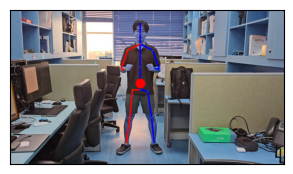

'squat_test_front'

In [21]:
pos_bias = np.array([0, 0, 0])

target_video = 'squat_test_front'
#target_video = 'squat_test'
pose_2d_list, W, H = get_squat_test_input(target_video, pos_bias=pos_bias, visulize=True)

if pos_bias.sum() != 0:
    target_video += f'_pos_bias_x{pos_bias[0]}_y{pos_bias[1]}'
target_video

### Inference

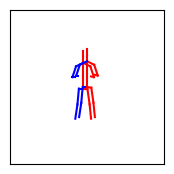

video_name: MB_ft_h36m_dh_angle10_lv10_lg10_with_canonical_squat_test_front_video.mp4
output_videos/squat_test_front/MB_ft_h36m_dh_angle10_lv10_lg10_with_canonical_squat_test_front_video.mp4


100%|██████████| 243/243 [00:07<00:00, 30.39it/s]


100%|██████████| 243/243 [00:07<00:00, 30.92it/s]


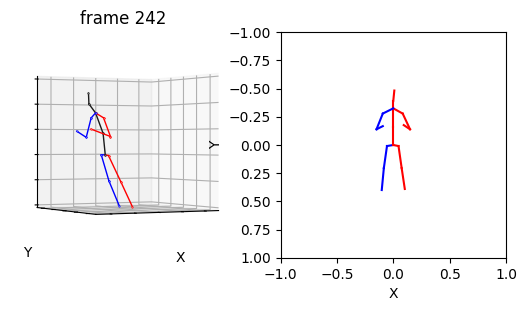

In [22]:
# inference
output, input_data, video_name = inference(args, 
                                           model_pos, 
                                           target_model, target_video,
                                           pose_2d_list, 
                                           W=W, H=H, 
                                           start_frame=0, clip_len=243, 
                                           input_type='video', 
                                           canonical_input=False, 
                                           visualize_input=True)

# save output video
save_mb_output_video(output, input_data, target_video, video_name)

In [ ]:
for target_model in ['MB_release', 'MB_train_h36m', 'MB_train_h36m_with_canonical2', 'MB_train_h36m_s1', 'MB_train_h36m_s1_with_canonical2', 'MB_ft_h36m']:
    opts = parse_args_by_model_name(target=target_model)
    args = get_config(opts.config)
    #print(opts.evaluate)

    if 'DHDST2' in opts.evaluate: model_pos = DHDSTformer2(chk_filename='', args=args)
    elif 'DHDST_torso' in opts.evaluate: model_pos = DHDSTformer_torso(chk_filename='', args=args)
    elif 'DHDSTformer_limb' in opts.evaluate: model_pos = DHDSTformer_limb(chk_filename='', args=args)
    elif 'MB' in opts.evaluate: model_pos = load_backbone(args)
        
    model_pos = nn.DataParallel(model_pos)
    model_pos = model_pos.cuda()
    checkpoint = torch.load(opts.evaluate, map_location=lambda storage, loc: storage)
    model_pos.load_state_dict(checkpoint['model_pos'], strict=True)
    model_pos = model_pos.eval()
    for pos_bias in [np.array([-500, 100, 0]), np.array([500, 100, 0]), np.array([0, 0, 0])]:  
        for target_video in ['squat_test_front', 'squat_test']:    
            pose_2d_list, W, H = get_squat_test_input(target_video, pos_bias=pos_bias, visulize=False)
            if pos_bias.sum() != 0:
                target_video += f'_pos_bias_x{pos_bias[0]}_y{pos_bias[1]}'
            #print(target_video)

            # inference
            output, input_data, video_name = inference(args, 
                                                    model_pos, 
                                                    target_model, target_video,
                                                    pose_2d_list, 
                                                    W=W, H=H, 
                                                    start_frame=0, clip_len=243, 
                                                    input_type='video', 
                                                    canonical_input=False, 
                                                    visualize_input=False)

            # save output video
            save_mb_output_video(output, input_data, target_video, video_name)

In [109]:
# # check output (1 frame)
# pose = get_rootrel_pose(output[0].copy()) # 1 frame
# #pose = get_rootrel_pose(output[0].copy()) # 1 frame
# print(pose.shape)
# R1 = Rotation.from_rotvec([-np.pi/2, 0, 0]).as_matrix() # -90 around x-axis
# R2 = Rotation.from_rotvec([0, 0, np.pi/2]).as_matrix() # 90 around z-axis
# pose = rotate_torso_by_R(pose, R2 @ R1)
# l_ankle = pose[get_h36m_keypoint_index('L_Ankle')]
# r_ankle = pose[get_h36m_keypoint_index('R_Ankle')]
# c_ankle = (l_ankle + r_ankle) / 2
# #pose -= c_ankle
# head = pose[get_h36m_keypoint_index('Head')]
# tilt = degrees(np.arctan2(head[2] - c_ankle[2], head[0] - c_ankle[0])) - 90
# R3 = Rotation.from_rotvec([0, np.radians(tilt), 0]).as_matrix() # tilt around y-axis
# #pose = rotate_torso_by_R(pose, R3)


# fig = plt.figure(5)
# fig.clear()
# ax = axes_3d(fig, xlim=(-0.5, 0.5), ylim=(-0.5, 0.5), zlim=(0, 1))
# draw_3d_pose(ax, pose)
# generate_world_frame().draw3d(scale=0.2, head_length=0.05)
# plt.show()

### Test on one video with various position

In [51]:
def get_custom_camera_info(camera):
    calibration_matrix = camera.intrinsic
    R = camera.R
    t = camera.t/1000
    H = camera.IMAGE_HEIGHT
    W = camera.IMAGE_WIDTH
    camera_param = {
        'intrinsic': calibration_matrix,
        'extrinsic': np.concatenate([R, t.reshape(3, 1)], axis=1),
    }
    fx = camera_param['intrinsic'][0, 0]  
    fy = camera_param['intrinsic'][1, 1]  
    cx = camera_param['intrinsic'][0, 2]  
    cy = camera_param['intrinsic'][1, 2] 
    return calibration_matrix, camera_param, H, W, fx, fy, cx, cy

def mpjpe(predicted, target):
    """
    Mean per-joint position error (i.e. mean Euclidean distance),
    often referred to as "Protocol #1" in many papers.
    """
    assert predicted.shape == target.shape
    return np.mean(np.linalg.norm(predicted - target, axis=len(target.shape)-1), axis=1)

In [4]:
h36m_3d_world, h36m_cam_param = load_h36m()

==> Loading 3D data wrt World CS...


In [5]:
subject = 'S5'
action = 'Waiting 1'
camera_id = '54138969'
target_video = f'{subject}_{action}_{camera_id}'

pose3d_list = h36m_3d_world._data[subject][action]['positions'].copy()
calibration_matrix, camera_param, H, W, fx, fy, cx, cy = get_h36m_camera_info(h36m_3d_world, h36m_cam_param, subject, action, camera_id)

pose_2d_list, cam_3d_list, img_3d_list, img_3d_hat_list, img_25d_list, scale_list = h36m_data_processing(pose3d_list, pose3d_list.copy(), camera_param, fx, fy, cx, cy)

In [52]:
# virtual camera 
cam_origin = np.array([0, -3, 1.5])

forward = [0, 1, 0]
left = [-1, 0, 0]
down = np.cross(left, forward)
cam_default_R = np.array([left, down, forward]) # default camera orientation

camera = Camera(origin=cam_origin, 
                calib_mat=np.array(calibration_matrix), 
                cam_default_R=cam_default_R, 
                IMAGE_HEIGHT=H, 
                IMAGE_WIDTH=W,
                cam_name='test')

subject = 'S5'
action = 'Waiting 1'
camera_id = '54138969'
target_video = f'{subject}_{action}_{camera_id}_custom_camera'

pose3d_list = h36m_3d_world._data[subject][action]['positions'].copy()
calibration_matrix, camera_param, H, W, fx, fy, cx, cy = get_custom_camera_info(camera)
pose_2d_list, cam_3d_list, img_3d_list, img_3d_hat_list, img_25d_list, scale_list = h36m_data_processing(pose3d_list, camera_param, fx, fy, cx, cy)
normalized_gt_3d = normalize_input(img_3d_list.copy(), W, H)

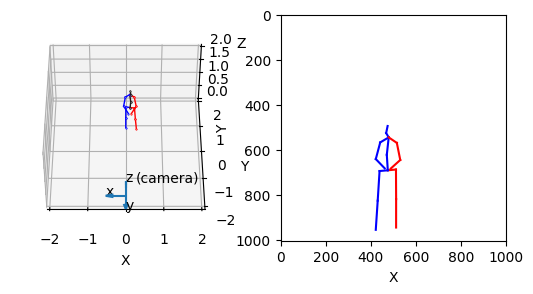

In [32]:
frame_num = 50
pose_3d = pose3d_list[frame_num]
pose_2d = pose_2d_list[frame_num]

%matplotlib inline
fig = plt.figure(6)
fig.clear()
ax = axes_3d(fig, loc=121, zlim=(0, 2), view=(45, -90))
draw_3d_pose(ax, pose_3d)
camera.cam_frame.draw3d()
ax2 = axes_2d(fig, loc=122, W=W, H=H)
draw_2d_pose(ax2, pose_2d)
plt.show()

In [128]:
for target_model in ['MB_release', 'MB_train_h36m', 'MB_train_h36m_with_canonical2', 'MB_train_h36m_s1', 'MB_train_h36m_s1_with_canonical2', 'MB_ft_h36m']:
    opts = parse_args_by_model_name(target=target_model)
    args = get_config(opts.config)
    #print(opts.evaluate)

    if 'DHDSTformer_total2' in opts.evaluate: model_pos = DHDSTformer_total2(chk_filename='', args=args)
    elif 'DHDSTformer_torso' in opts.evaluate: model_pos = DHDSTformer_torso(chk_filename='', args=args)
    elif 'DHDSTformer_limb' in opts.evaluate: model_pos = DHDSTformer_limb(chk_filename='', args=args)
    elif 'MB' in opts.evaluate: model_pos = load_backbone(args)
        
    model_pos = nn.DataParallel(model_pos)
    model_pos = model_pos.cuda()
    checkpoint = torch.load(opts.evaluate, map_location=lambda storage, loc: storage)
    model_pos.load_state_dict(checkpoint['model_pos'], strict=True)
    model_pos = model_pos.eval()

    # inference
    output, input_data, video_name = inference(args, 
                                            model_pos, 
                                            target_model, target_video,
                                            pose_2d_list, 
                                            W=W, H=H, 
                                            start_frame=0, clip_len=243, 
                                            input_type='video', 
                                            canonical_input=False, 
                                            visualize_input=False)
    
    normalized_gt_3d = get_rootrel_pose(normalized_gt_3d)
    output = get_rootrel_pose(output)

    mpjpe_error = mpjpe(normalized_gt_3d, output)
    mpjpe_error_scaled = mpjpe_error* scale_list
    print(mpjpe_error_scaled.mean()*1000)

    

    # save output video
    save_mb_output_video(output, input_data, target_video, video_name, on_ground=False, gt=normalized_gt_3d)
    
    #break

video_name: MB_release_S5_Waiting 1_54138969_custom_camera_video.mp4
182.08212940791964
output_videos/S5_Waiting 1_54138969_custom_camera/MB_release_S5_Waiting 1_54138969_custom_camera_video.mp4


100%|██████████| 243/243 [00:10<00:00, 22.65it/s]


video_name: MB_train_h36m_S5_Waiting 1_54138969_custom_camera_video.mp4
228.52633922149164
output_videos/S5_Waiting 1_54138969_custom_camera/MB_train_h36m_S5_Waiting 1_54138969_custom_camera_video.mp4


100%|██████████| 243/243 [00:10<00:00, 22.90it/s]


video_name: MB_train_h36m_with_canonical2_S5_Waiting 1_54138969_custom_camera_video.mp4
232.4084314735041
output_videos/S5_Waiting 1_54138969_custom_camera/MB_train_h36m_with_canonical2_S5_Waiting 1_54138969_custom_camera_video.mp4


100%|██████████| 243/243 [00:10<00:00, 23.08it/s]


video_name: MB_train_h36m_s1_S5_Waiting 1_54138969_custom_camera_video.mp4
910.8786202677896
output_videos/S5_Waiting 1_54138969_custom_camera/MB_train_h36m_s1_S5_Waiting 1_54138969_custom_camera_video.mp4


100%|██████████| 243/243 [00:10<00:00, 23.06it/s]


video_name: MB_train_h36m_s1_with_canonical2_S5_Waiting 1_54138969_custom_camera_video.mp4
177.0368236995741
output_videos/S5_Waiting 1_54138969_custom_camera/MB_train_h36m_s1_with_canonical2_S5_Waiting 1_54138969_custom_camera_video.mp4


100%|██████████| 243/243 [00:10<00:00, 22.47it/s]


video_name: MB_ft_h36m_S5_Waiting 1_54138969_custom_camera_video.mp4
213.51357798817125
output_videos/S5_Waiting 1_54138969_custom_camera/MB_ft_h36m_S5_Waiting 1_54138969_custom_camera_video.mp4


100%|██████████| 243/243 [00:10<00:00, 23.45it/s]


(243, 17, 3) (243, 17, 3)


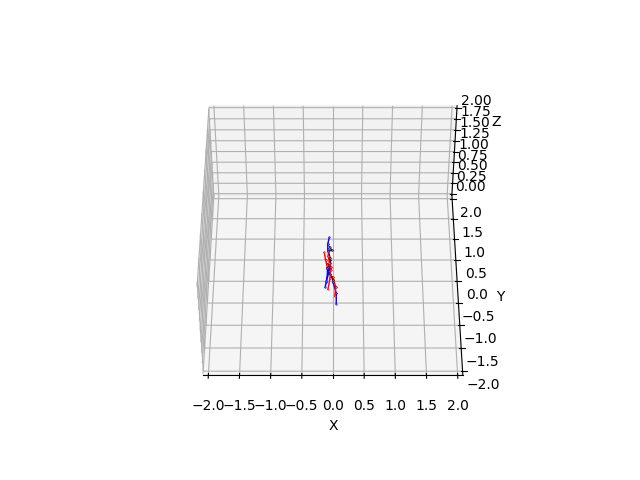

In [125]:
R1 = Rotation.from_rotvec([-np.pi/2, 0, 0]).as_matrix() # -90 around x-axis
R2 = Rotation.from_rotvec([0, 0, -np.pi/2]).as_matrix() # 90 around z-axis
R3 = Rotation.from_rotvec([0, 0, np.pi/2]).as_matrix() # 30 around y-axis
pose = rotate_torso_by_R(output, R2 @ R1)
pose2 = rotate_torso_by_R(normalized_gt_3d, R3 @ R1) 
print(pose.shape, pose2.shape)

%matplotlib widget
fig = plt.figure(7)
fig.clear()
ax = axes_3d(fig, zlim=(0, 2), view=(45, -90))
draw_3d_pose(ax, pose[0])
draw_3d_pose(ax, pose2[0])
plt.show()

### VideoPose

### Data Loading (h36m)

In [5]:
args.dt_file = 'h36m_sh_conf_cam_source_final.pkl'
args.subset_list = ['H36M-SH']
datareader = DataReaderH36M(n_frames=args.clip_len, sample_stride=args.sample_stride, data_stride_train=args.data_stride, data_stride_test=args.clip_len, dt_root = 'data/motion3d', dt_file=args.dt_file)
testloader_params = {
        'batch_size': args.batch_size,
        'shuffle': False,
        'num_workers': 12,
        'pin_memory': True,
        'prefetch_factor': 4,
        'persistent_workers': True
}
test_dataset = MotionDataset3D(args, args.subset_list, 'test')
test_loader = DataLoader(test_dataset, **testloader_params)

In [31]:
results_all = []
gts_all = []
inputs_all = []
model_pos.eval()            
with torch.no_grad():
    for batch_input, batch_gt in tqdm(test_loader): # batch_input: normalized joint_2d, batch_gt: normalized joint3d_image
        N, T = batch_gt.shape[:2] # batch_size, 243
        if torch.cuda.is_available():
            batch_input = batch_input.cuda()
        if args.no_conf:
            batch_input = batch_input[:, :, :, :2]
        if args.canonical:
            batch_input = batch_input - batch_input[:, :, 0:1, :] # root-relative
            batch_gt = batch_gt - batch_gt[:, :, 0:1, :]
        if batch_gt.shape[2] == 17:
            batch_gt_torso = batch_gt[:, :, [0, 1, 4, 7, 8, 9, 10, 11, 14], :] 
            batch_gt_limb_pos = batch_gt[:, :, [2, 3, 5, 6, 12, 13, 15, 16], :]
        # inference
        if args.flip:    
            batch_input_flip = flip_data(batch_input)
            if 'DHDSTformer_total' in args.model:
                predicted_3d_pos_1 = model_pos(batch_input, length_type=args.test_length_type, ref_frame=args.length_frame)
                predicted_3d_pos_flip = model_pos(batch_input_flip, length_type=args.test_length_type, ref_frame=args.length_frame)
                predicted_3d_pos_2 = flip_data(predicted_3d_pos_flip)                   # Flip back
                predicted_3d_pos = (predicted_3d_pos_1+predicted_3d_pos_2) / 2
            elif 'DHDSTformer_limb' in args.model:
                predicted_3d_pos_1 = model_pos(batch_input, batch_gt_torso)
                predicted_3d_pos_flip = model_pos(batch_input_flip, batch_gt_torso)
                predicted_3d_pos_2 = flip_data(predicted_3d_pos_flip)                   # Flip back
                predicted_3d_pos = (predicted_3d_pos_1+predicted_3d_pos_2) / 2
            elif 'DHDSTformer_torso' in args.model:
                pred_torso_1, pred_lower_frame_R1, pred_upper_frame_R1 = model_pos(batch_input)
                pred_torso_flip, pred_lower_frame_R_flip, pred_upper_frame_R_flip = model_pos(batch_input_flip)
                pred_torso_2, pred_lower_frame_R2, pred_upper_frame_R2 = flip_data(pred_torso_flip)                   # Flip back
                pred_torso = (pred_torso_1+pred_torso_2) / 2
            elif 'DHDSTformer_torso2' in args.model:
                pred_torso_1 = model_pos(batch_input)
                pred_torso_flip = model_pos(batch_input_flip)
                pred_torso_2 = flip_data(pred_torso_flip)
                pred_torso = (pred_torso_1+pred_torso_2) / 2
            else:
                predicted_3d_pos_1 = model_pos(batch_input)
                predicted_3d_pos_flip = model_pos(batch_input_flip)
                predicted_3d_pos_2 = flip_data(predicted_3d_pos_flip)                   # Flip back
                predicted_3d_pos = (predicted_3d_pos_1+predicted_3d_pos_2) / 2
        else:
            if 'DHDSTformer_total' in args.model:
                predicted_3d_pos = model_pos(batch_input, length_type=args.test_length_type, ref_frame=args.length_frame)
            elif 'DHDSTformer_limb' in args.model:
                predicted_3d_pos = model_pos(batch_input, batch_gt_torso)
            elif 'DHDSTformer_torso' in args.model:
                pred_torso, pred_lower_frame_R, pred_upper_frame_R = model_pos(batch_input)
                predicted_3d_pos = pred_torso
            elif 'DHDSTformer_torso2' in args.model:
                pred_torso = model_pos(batch_input)
                predicted_3d_pos = pred_torso
            else:
                predicted_3d_pos = model_pos(batch_input)
        
        if args.rootrel:
            predicted_3d_pos[:,:,0,:] = 0     # [N,T,17,3]
        else:
            batch_gt[:,0,0,2] = 0
        if args.gt_2d: # input 2d를 추론값으로 사용함으로써 depth만 추정하도록 함
            predicted_3d_pos[...,:2] = batch_input[...,:2]
        results_all.append(predicted_3d_pos.cpu().numpy())
        gts_all.append(batch_gt.cpu().numpy())
        inputs_all.append(batch_input.cpu().numpy())
        #break
        
results_all = np.concatenate(results_all)
gts_all = np.concatenate(gts_all)
inputs_all = np.concatenate(inputs_all)
# results_all = datareader.denormalize(results_all) # denormalize the predicted 3D poses
# gts_all = datareader.denormalize(gts_all) # denormalize the ground truth 3D poses
# inputs_all = datareader.denormalize(inputs_all) # denormalize the input 2D poses

100%|██████████| 140/140 [00:58<00:00,  2.40it/s]


In [30]:
target_model, args.subset_list[0]

('MB_train_h36m_with_canonical2', 'H36M-SH')

In [32]:
# save result
result_dict = {
    'results_all': results_all,
    'gts_all': gts_all,
    'inputs_all': inputs_all,
}

savepkl(result_dict, f'result_dict_{target_model}_{args.subset_list[0]}.pkl')

### evaluate function

In [13]:
# def postprocessing(pose):
#     #pose = get_rootrel_pose(output[0].copy()) # 1 frame
#     print(pose.shape)
#     R1 = Rotation.from_rotvec([-np.pi/2, 0, 0]).as_matrix() # -90 around x-axis
#     R2 = Rotation.from_rotvec([0, 0, np.pi/2]).as_matrix() # 90 around z-axis
#     pose = rotate_torso_by_R(pose, R2 @ R1)
#     l_ankle = pose[get_h36m_keypoint_index('L_Ankle')]
#     r_ankle = pose[get_h36m_keypoint_index('R_Ankle')]
#     c_ankle = (l_ankle + r_ankle) / 2
#     #pose -= c_ankle
#     head = pose[get_h36m_keypoint_index('Head')]
#     tilt = degrees(np.arctan2(head[2] - c_ankle[2], head[0] - c_ankle[0])) - 90
#     R3 = Rotation.from_rotvec([0, np.radians(tilt), 0]).as_matrix() # tilt around y-axis
#     #pose = rotate_torso_by_R(pose, R3)
#     return pose

In [5]:
from train_custom import evaluate
args.canonical = False
args.part_list = ['torso_small']
args.eval_part = 'torso_small'

In [7]:
e1, e2, results_all, total_result_dict = evaluate(args, model_pos, test_loader, datareader)

INFO: Testing


  0%|          | 0/140 [00:00<?, ?it/s]

100%|██████████| 140/140 [01:05<00:00,  2.13it/s]


Part: torso_small
+------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+
|    test_name     |     Direction      |      Discuss       |       Eating       |       Greet        |       Phone       |       Photo        |        Pose        |      Purchase      |      Sitting       |    SittingDown     |       Smoke        |        Wait        |        Walk        |      WalkDog       |      WalkTwo      |
+------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-

### Compare Procrustes alignment

0.21677281 0.014367135


/home/hrai/miniconda3/envs/motionbert/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


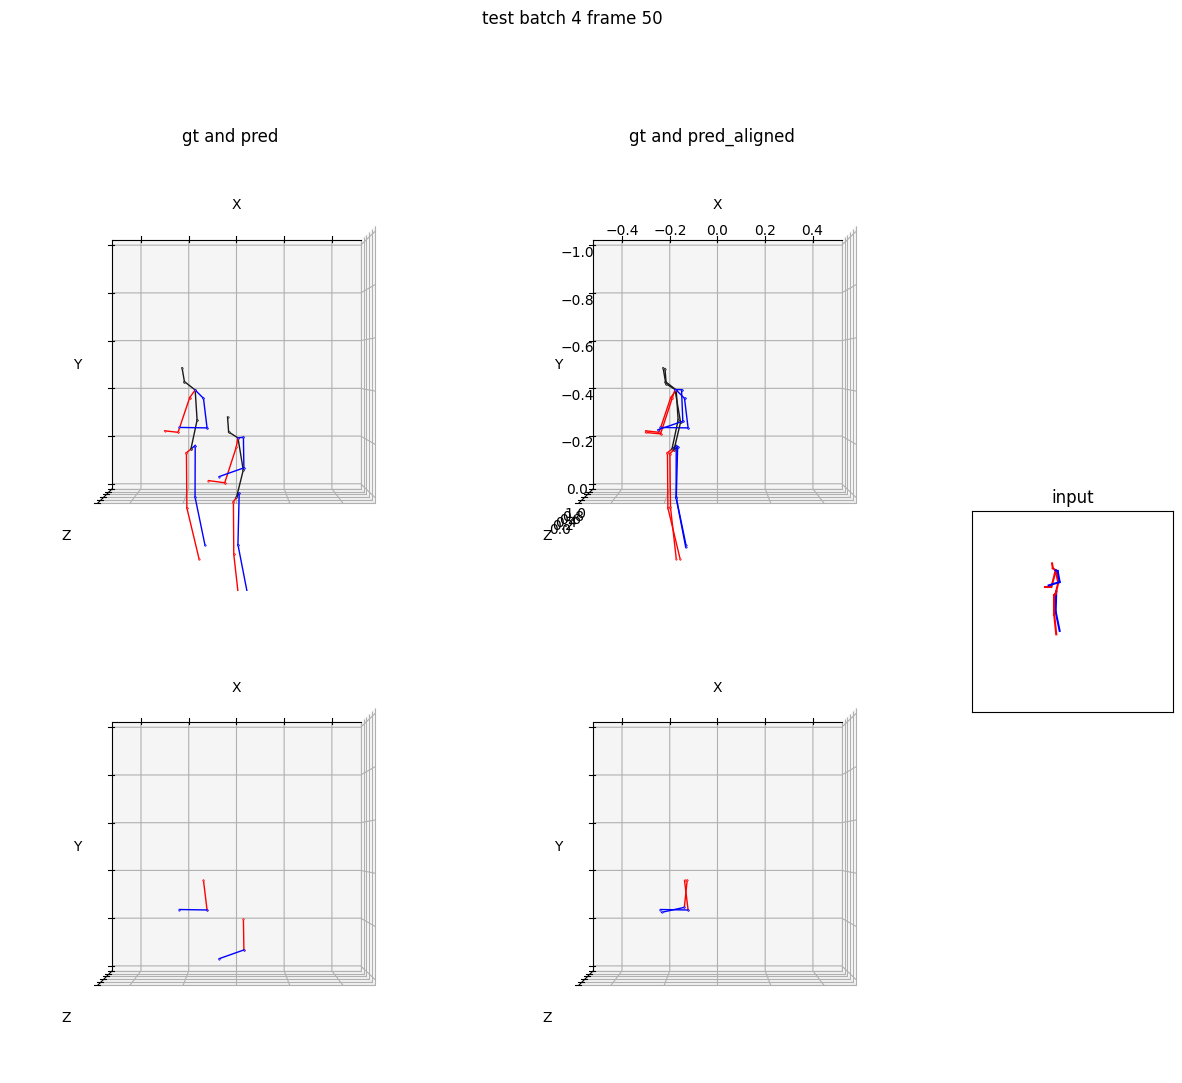

In [19]:
batch_num = 4
frame_num = 50
pred_3d_pos = results_all[batch_num].copy() # [243, 17, 3]
gt_3d_pos = gts_all[batch_num].copy() # [243, 17, 3]
input_2d = inputs_all[batch_num].copy()

part = part_ids['R_ARM']
pred_right_arm = pred_3d_pos[:, h36m_part_keypoints[part]] 
gt_right_arm = gt_3d_pos[:, h36m_part_keypoints[part]]

pred_3d_pos_aligned = procrustes_align(pred_3d_pos, gt_3d_pos)
pred_right_arm_aligned = procrustes_align(pred_right_arm, gt_right_arm)

from lib.model.loss import *
mpjpe_3d_pos = mpjpe(pred_3d_pos, gt_3d_pos)
p_mpjpe_3d_pos = p_mpjpe(pred_3d_pos, gt_3d_pos)
print(mpjpe_3d_pos.mean(), p_mpjpe_3d_pos.mean())

%matplotlib inline
fig = plt.figure(8, figsize=(15, 12), layout='constrained')
fig.clear()
axd = fig.subplot_mosaic(
    """
    AABBC
    AABBC
    DDEEC
    DDEEC
    """,
    per_subplot_kw={('A', 'B', 'D', 'E'): {'projection': '3d'}}
)
axA = axes_3d(ax=axd['A'], xlim=(-0.5, 0.5), ylim=(-1, 0), zlim=(0, 1), view=(-90,-90), show_axis=False)
axB = axes_3d(ax=axd['B'], xlim=(-0.5, 0.5), ylim=(-1, 0), zlim=(0, 1), view=(-90,-90), show_axis=True)
axC = axes_2d(ax=axd['C'], normalize=True, show_axis=False)
axD = axes_3d(ax=axd['D'], xlim=(-0.5, 0.5), ylim=(-1, 0), zlim=(0, 1), view=(-90,-90), show_axis=False)
axE = axes_3d(ax=axd['E'], xlim=(-0.5, 0.5), ylim=(-1, 0), zlim=(0, 1), view=(-90,-90), show_axis=False)

axA.set_title('gt and pred')
axB.set_title('gt and pred_aligned')
axC.set_title('input')

dataset = 'h36m'

draw_3d_pose(axA, gt_3d_pos[frame_num], dataset=dataset)
draw_3d_pose(axA, pred_3d_pos[frame_num], dataset=dataset)

draw_3d_pose(axB, gt_3d_pos[frame_num], dataset=dataset)
draw_3d_pose(axB, pred_3d_pos_aligned[frame_num], dataset=dataset)

draw_2d_pose(axC, input_2d[frame_num], normalize=True)

draw_3d_pose(axD, gt_right_arm[frame_num], dataset='limb')
draw_3d_pose(axD, pred_right_arm[frame_num], dataset='limb')

draw_3d_pose(axE, gt_right_arm[frame_num], dataset='limb')
draw_3d_pose(axE, pred_right_arm_aligned[frame_num], dataset='limb')

plt.suptitle(f'test batch {batch_num} frame {frame_num}')
plt.show()

### Length Consistency

In [20]:
batch_num = 0
pred_3d_pos = results_all[batch_num].copy()
gt_3d_pos = gts_all[batch_num].copy()

gt_length = get_h36m_limb_lens(gt_3d_pos.copy()) # (243, 16)
pred_length = get_h36m_limb_lens(pred_3d_pos.copy()) # (243, 16)

gt_ref = gt_length[:, len_ids['R_HIP']] + gt_length[:, len_ids['L_HIP']]

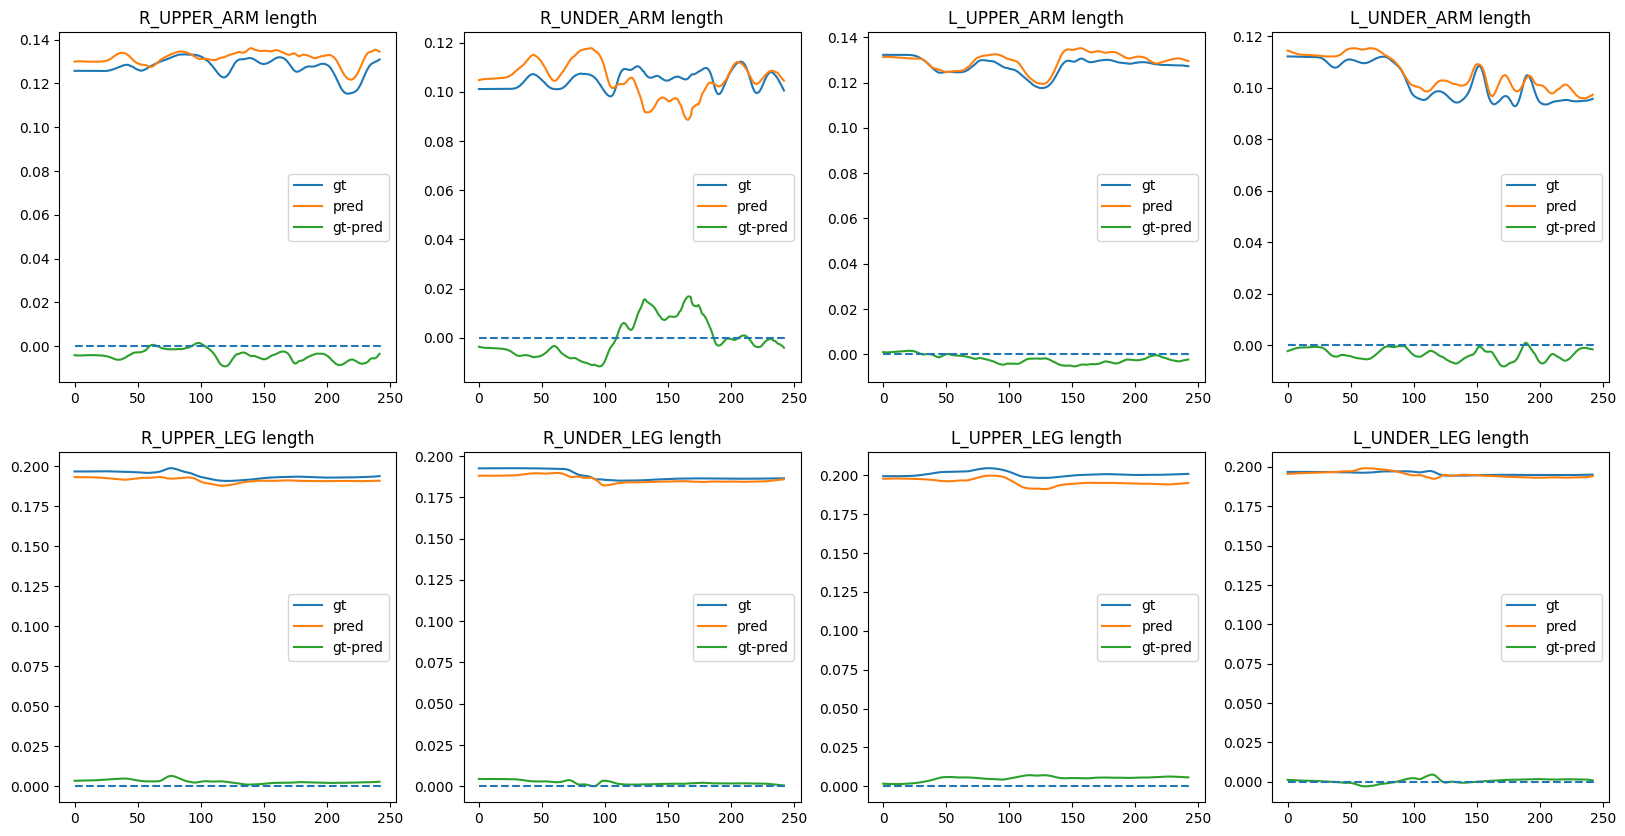

In [21]:
%matplotlib inline
fig = plt.figure(9, figsize=(20, 10))
fig.clear()
axd = fig.subplot_mosaic(
    """
    ABCD
    EFGH
    """,
    #per_subplot_kw={('A', 'B', 'C', 'D', 'E'): {'projection': '3d'}}
)

part_list = ['R_UPPER_ARM', 
             'R_UNDER_ARM', 
             'L_UPPER_ARM', 
             'L_UNDER_ARM', 
             'R_UPPER_LEG', 
             'R_UNDER_LEG', 
             'L_UPPER_LEG', 
             'L_UNDER_LEG']

for ax, part in zip(axd.values(), part_list):
    ax.plot(gt_length[:, len_ids[part]], label='gt')
    ax.plot(pred_length[:, len_ids[part]], label='pred')
    ax.plot(gt_length[:, len_ids[part]]-pred_length[:, len_ids[part]], label='gt-pred')
    ax.hlines(0, xmin=0, xmax=len(gt_length[:, len_ids[part]]) ,linestyles='--')
    ax.legend()
    ax.set_title(f'{part} length')
    
plt.show()

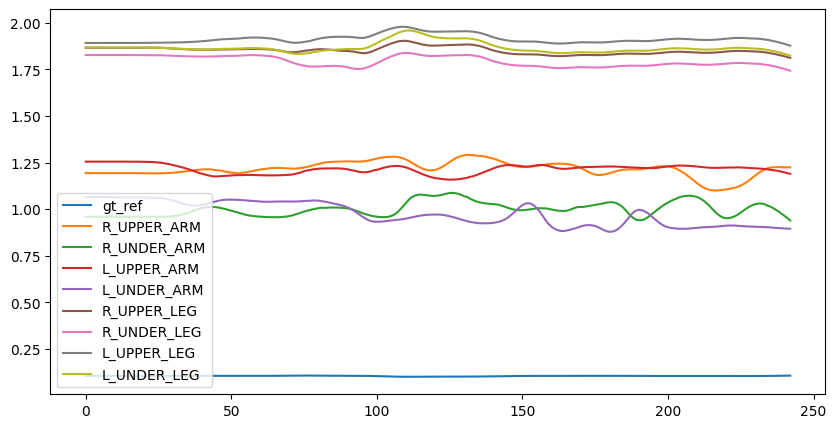

In [22]:
%matplotlib inline
fig = plt.figure(9, figsize=(10, 5))
fig.clear()
ax = fig.add_subplot(111)
ax.plot(gt_ref, label='gt_ref')
for part in part_list:
    ax.plot(gt_length[:, len_ids[part]]/gt_ref, label=part)
ax.legend()
plt.show()

### Angle

In [20]:
batch_pred_angle = get_limb_angle(results_all)
batch_gt_angle = get_limb_angle(gts_all)
batch_pred_angle.shape, batch_gt_angle.shape

(torch.Size([128, 243, 2]), torch.Size([128, 243, 2]))

In [21]:
batch_pred_r_upper_leg = batch_pred_angle[0::8]
batch_pred_l_upper_leg = batch_pred_angle[1::8]
batch_pred_r_upper_arm = batch_pred_angle[2::8]
batch_pred_l_upper_arm = batch_pred_angle[3::8]
batch_pred_r_under_leg = batch_pred_angle[4::8]
batch_pred_l_under_leg = batch_pred_angle[5::8]
batch_pred_r_under_arm = batch_pred_angle[6::8]
batch_pred_l_under_arm = batch_pred_angle[7::8]
batch_gt_r_upper_leg = batch_gt_angle[0::8]
batch_gt_l_upper_leg = batch_gt_angle[1::8]
batch_gt_r_upper_arm = batch_gt_angle[2::8]
batch_gt_l_upper_arm = batch_gt_angle[3::8]
batch_gt_r_under_leg = batch_gt_angle[4::8]
batch_gt_l_under_leg = batch_gt_angle[5::8]
batch_gt_r_under_arm = batch_gt_angle[6::8]
batch_gt_l_under_arm = batch_gt_angle[7::8]


batch_pred_r_upper_leg.shape, batch_pred_l_upper_leg.shape, batch_pred_r_upper_arm.shape, batch_pred_l_upper_arm.shape

(torch.Size([16, 243, 2]),
 torch.Size([16, 243, 2]),
 torch.Size([16, 243, 2]),
 torch.Size([16, 243, 2]))

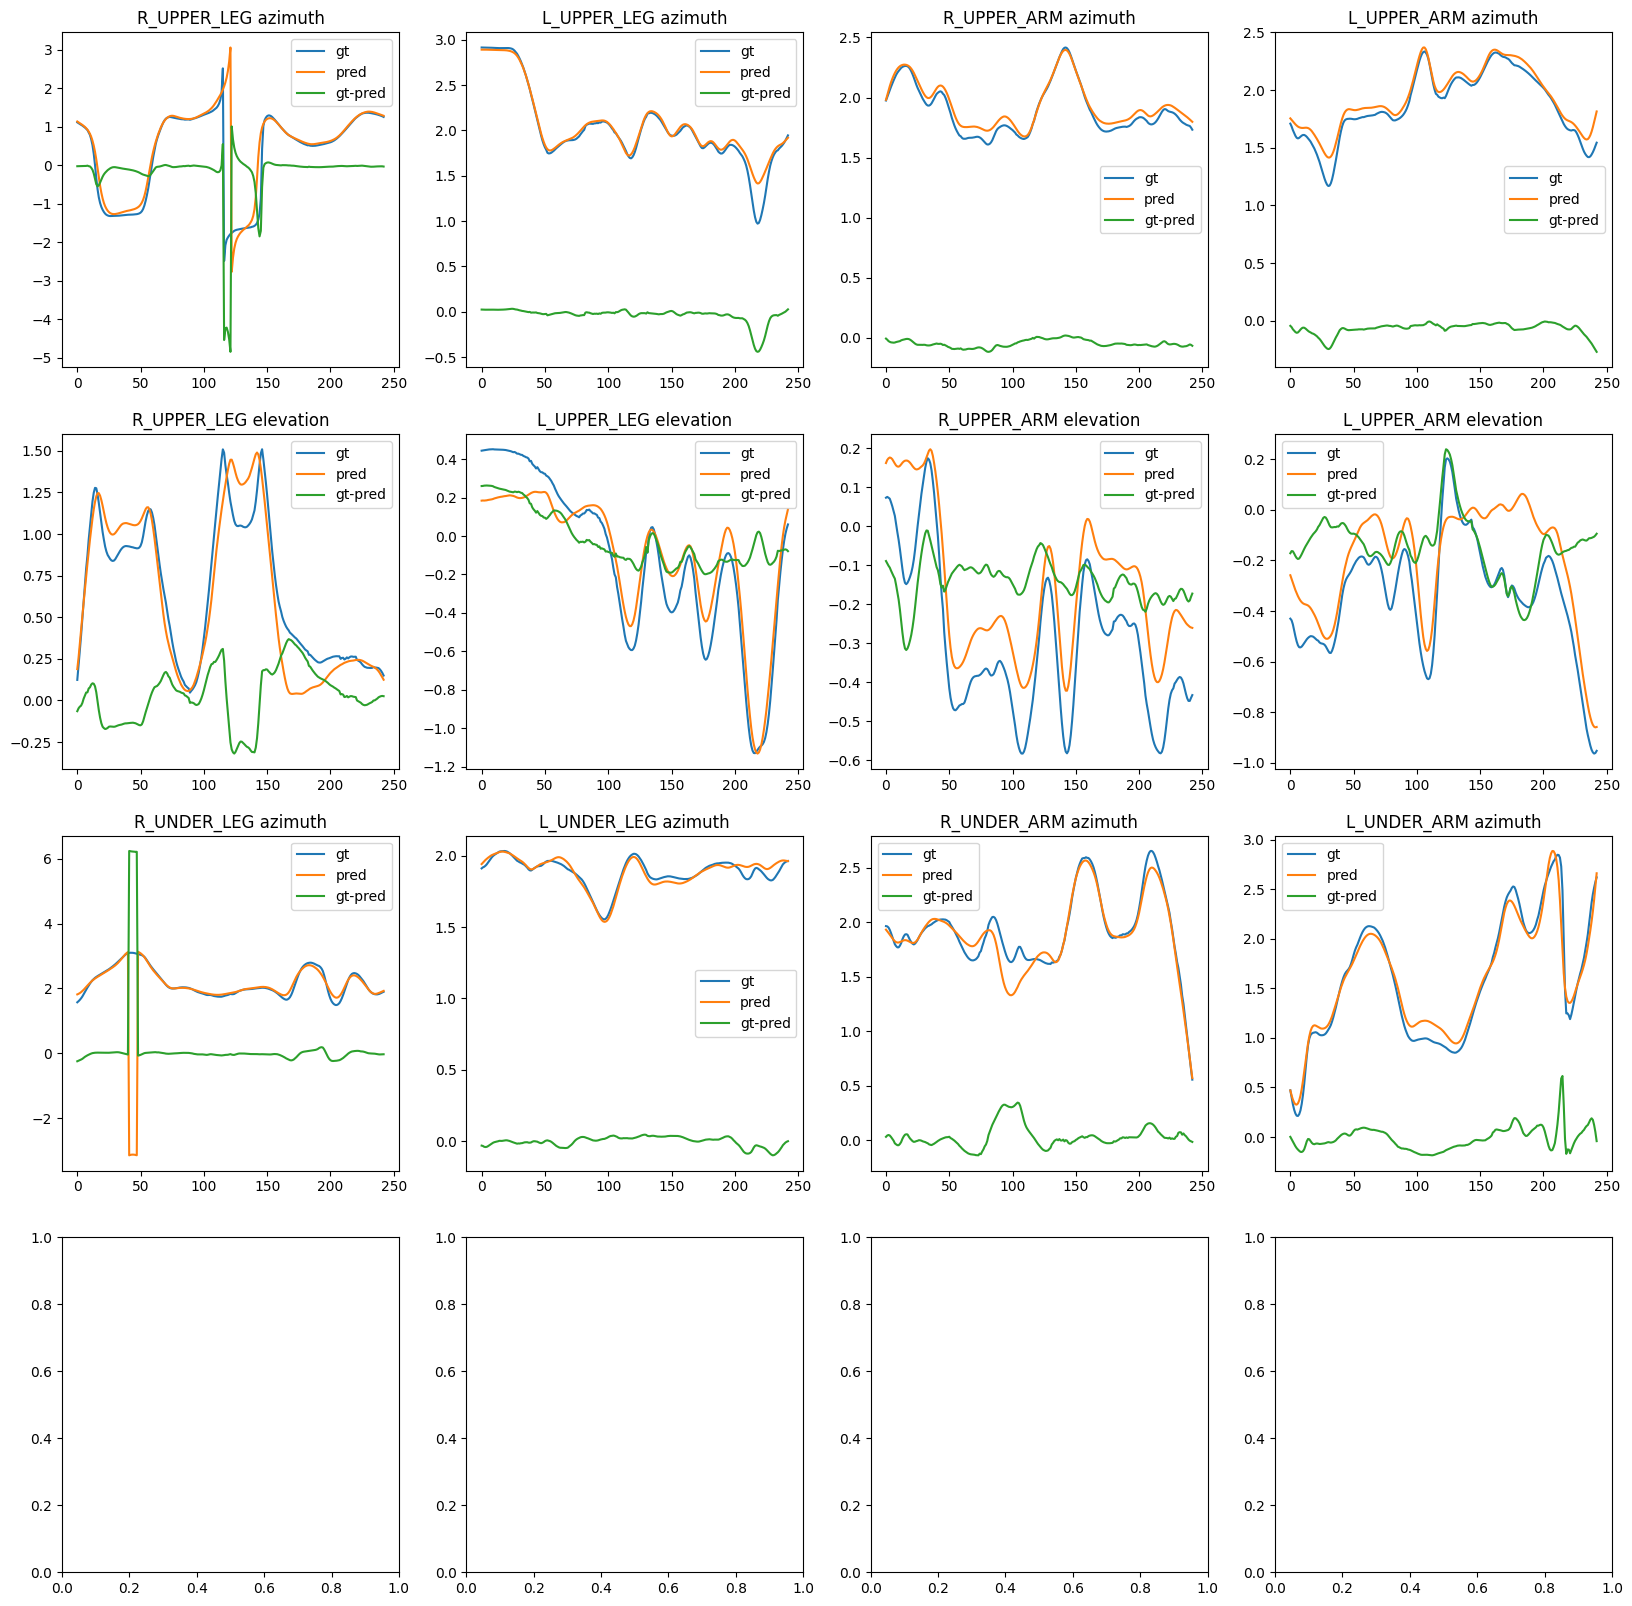

In [24]:
%matplotlib inline
fig = plt.figure(10, figsize=(20, 20))
fig.clear()
axd = fig.subplot_mosaic(
    """
    ABCD
    EFGH
    IJKL
    MNOP
    """,
    #per_subplot_kw={('A', 'B', 'C', 'D', 'E'): {'projection': '3d'}}
)

batch_num = 5

pred_r_upper_leg = batch_pred_r_upper_leg[batch_num]
pred_l_upper_leg = batch_pred_l_upper_leg[batch_num]
pred_r_upper_arm = batch_pred_r_upper_arm[batch_num]
pred_l_upper_arm = batch_pred_l_upper_arm[batch_num]
pred_r_under_leg = batch_pred_r_under_leg[batch_num]
pred_l_under_leg = batch_pred_l_under_leg[batch_num]
pred_r_under_arm = batch_pred_r_under_arm[batch_num]
pred_l_under_arm = batch_pred_l_under_arm[batch_num]

gt_r_upper_leg = batch_gt_r_upper_leg[batch_num]
gt_l_upper_leg = batch_gt_l_upper_leg[batch_num]
gt_r_upper_arm = batch_gt_r_upper_arm[batch_num]
gt_l_upper_arm = batch_gt_l_upper_arm[batch_num]
gt_r_under_leg = batch_gt_r_under_leg[batch_num]
gt_l_under_leg = batch_gt_l_under_leg[batch_num]
gt_r_under_arm = batch_gt_r_under_arm[batch_num]
gt_l_under_arm = batch_gt_l_under_arm[batch_num]


pred_r_upper_leg_azim = pred_r_upper_leg[:, 0]
pred_r_upper_leg_elev = pred_r_upper_leg[:, 1]
pred_l_upper_leg_azim = pred_l_upper_leg[:, 0]
pred_l_upper_leg_elev = pred_l_upper_leg[:, 1]
pred_r_upper_arm_azim = pred_r_upper_arm[:, 0]
pred_r_upper_arm_elev = pred_r_upper_arm[:, 1]
pred_l_upper_arm_azim = pred_l_upper_arm[:, 0]
pred_l_upper_arm_elev = pred_l_upper_arm[:, 1]
pred_r_under_leg_azim = pred_r_under_leg[:, 0]
pred_r_under_leg_elev = pred_r_under_leg[:, 1]
pred_l_under_leg_azim = pred_l_under_leg[:, 0]
pred_l_under_leg_elev = pred_l_under_leg[:, 1]
pred_r_under_arm_azim = pred_r_under_arm[:, 0]
pred_r_under_arm_elev = pred_r_under_arm[:, 1]
pred_l_under_arm_azim = pred_l_under_arm[:, 0]
pred_l_under_arm_elev = pred_l_under_arm[:, 1]
gt_r_upper_leg_azim = gt_r_upper_leg[:, 0]
gt_r_upper_leg_elev = gt_r_upper_leg[:, 1]
gt_l_upper_leg_azim = gt_l_upper_leg[:, 0]
gt_l_upper_leg_elev = gt_l_upper_leg[:, 1]
gt_r_upper_arm_azim = gt_r_upper_arm[:, 0]
gt_r_upper_arm_elev = gt_r_upper_arm[:, 1]
gt_l_upper_arm_azim = gt_l_upper_arm[:, 0]
gt_l_upper_arm_elev = gt_l_upper_arm[:, 1]
gt_r_under_leg_azim = gt_r_under_leg[:, 0]
gt_r_under_leg_elev = gt_r_under_leg[:, 1]
gt_l_under_leg_azim = gt_l_under_leg[:, 0]
gt_l_under_leg_elev = gt_l_under_leg[:, 1]
gt_r_under_arm_azim = gt_r_under_arm[:, 0]
gt_r_under_arm_elev = gt_r_under_arm[:, 1]
gt_l_under_arm_azim = gt_l_under_arm[:, 0]
gt_l_under_arm_elev = gt_l_under_arm[:, 1]

axd['A'].plot(gt_r_upper_leg_azim, label='gt')
axd['A'].plot(pred_r_upper_leg_azim, label='pred')
axd['A'].plot(gt_r_upper_leg_azim-pred_r_upper_leg_azim, label='gt-pred')
axd['A'].set_title('R_UPPER_LEG azimuth')
axd['A'].legend()

axd['B'].plot(gt_l_upper_leg_azim, label='gt')
axd['B'].plot(pred_l_upper_leg_azim, label='pred')
axd['B'].plot(gt_l_upper_leg_azim-pred_l_upper_leg_azim, label='gt-pred')
axd['B'].set_title('L_UPPER_LEG azimuth')
axd['B'].legend()

axd['C'].plot(gt_r_upper_arm_azim, label='gt')
axd['C'].plot(pred_r_upper_arm_azim, label='pred')
axd['C'].plot(gt_r_upper_arm_azim-pred_r_upper_arm_azim, label='gt-pred')
axd['C'].set_title('R_UPPER_ARM azimuth')
axd['C'].legend()

axd['D'].plot(gt_l_upper_arm_azim, label='gt')
axd['D'].plot(pred_l_upper_arm_azim, label='pred')
axd['D'].plot(gt_l_upper_arm_azim-pred_l_upper_arm_azim, label='gt-pred')
axd['D'].set_title('L_UPPER_ARM azimuth')
axd['D'].legend()

axd['E'].plot(gt_r_upper_leg_elev, label='gt')
axd['E'].plot(pred_r_upper_leg_elev, label='pred')
axd['E'].plot(gt_r_upper_leg_elev-pred_r_upper_leg_elev, label='gt-pred')
axd['E'].set_title('R_UPPER_LEG elevation')
axd['E'].legend()

axd['F'].plot(gt_l_upper_leg_elev, label='gt')
axd['F'].plot(pred_l_upper_leg_elev, label='pred')
axd['F'].plot(gt_l_upper_leg_elev-pred_l_upper_leg_elev, label='gt-pred')
axd['F'].set_title('L_UPPER_LEG elevation')
axd['F'].legend()

axd['G'].plot(gt_r_upper_arm_elev, label='gt')
axd['G'].plot(pred_r_upper_arm_elev, label='pred')
axd['G'].plot(gt_r_upper_arm_elev-pred_r_upper_arm_elev, label='gt-pred')
axd['G'].set_title('R_UPPER_ARM elevation')
axd['G'].legend()

axd['H'].plot(gt_l_upper_arm_elev, label='gt')
axd['H'].plot(pred_l_upper_arm_elev, label='pred')
axd['H'].plot(gt_l_upper_arm_elev-pred_l_upper_arm_elev, label='gt-pred')
axd['H'].set_title('L_UPPER_ARM elevation')
axd['H'].legend()

axd['I'].plot(gt_r_under_leg_azim, label='gt')
axd['I'].plot(pred_r_under_leg_azim, label='pred')
axd['I'].plot(gt_r_under_leg_azim-pred_r_under_leg_azim, label='gt-pred')
axd['I'].set_title('R_UNDER_LEG azimuth')
axd['I'].legend()

axd['J'].plot(gt_l_under_leg_azim, label='gt')
axd['J'].plot(pred_l_under_leg_azim, label='pred')
axd['J'].plot(gt_l_under_leg_azim-pred_l_under_leg_azim, label='gt-pred')
axd['J'].set_title('L_UNDER_LEG azimuth')
axd['J'].legend()

axd['K'].plot(gt_r_under_arm_azim, label='gt')
axd['K'].plot(pred_r_under_arm_azim, label='pred')
axd['K'].plot(gt_r_under_arm_azim-pred_r_under_arm_azim, label='gt-pred')
axd['K'].set_title('R_UNDER_ARM azimuth')
axd['K'].legend()

axd['L'].plot(gt_l_under_arm_azim, label='gt')
axd['L'].plot(pred_l_under_arm_azim, label='pred')
axd['L'].plot(gt_l_under_arm_azim-pred_l_under_arm_azim, label='gt-pred')
axd['L'].set_title('L_UNDER_ARM azimuth')
axd['L'].legend()

plt.show()


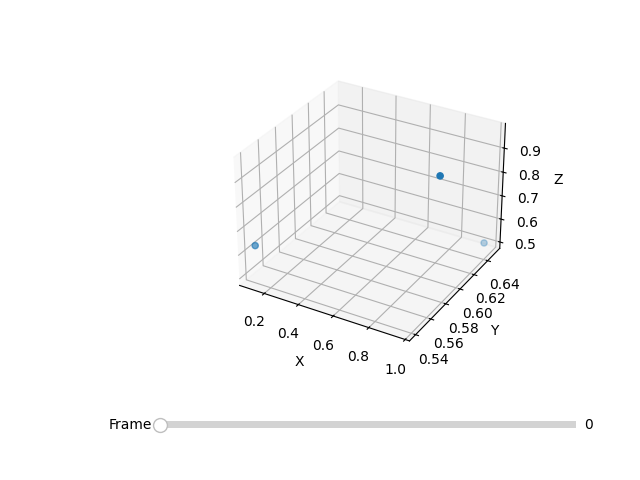

In [26]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
from mpl_toolkits.mplot3d import Axes3D

# 예제 데이터: 243 프레임에 대한 임의의 3D 포즈 데이터
# 여기서는 간단한 예시로 각 포즈가 3개의 점으로 구성되어 있으며, 각 점은 (x, y, z) 좌표를 가집니다.
# 실제 데이터에 맞게 조정해주세요.
data = np.random.rand(243, 3, 3)  # (프레임 수, 점의 수, 좌표)

# 초기 프레임 설정
initial_frame = 0

# 그래프 설정
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.subplots_adjust(left=0.25, bottom=0.25)

# 슬라이더를 위한 축
axcolor = 'lightgoldenrodyellow'
axframe = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)

# 슬라이더 초기화
frame_slider = Slider(ax=axframe, label='Frame', valmin=0, valmax=242, valinit=initial_frame, valfmt='%0.0f')

# 포즈를 그리는 함수
def update(val):
    frame = int(frame_slider.val)
    ax.clear()
    ax.scatter(data[frame, :, 0], data[frame, :, 1], data[frame, :, 2])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.draw()

# 슬라이더 값이 변경될 때마다 update 함수 호출
frame_slider.on_changed(update)

# 초기 포즈 표시
update(initial_frame)

plt.show()


In [41]:
def get_limb_lens(x):
    '''
        Input: (N, T, 17, 3)
        Output: (N, T, 16)
    '''
    limbs_id = [[0,1], [1,2], [2,3],
         [0,4], [4,5], [5,6],
         [0,7], [7,8], [8,9], [9,10],
         [8,11], [11,12], [12,13],
         [8,14], [14,15], [15,16]
        ]
    limbs = x[:,limbs_id,:]
    limbs = limbs[:,:,0,:]-limbs[:,:,1,:]
    limb_lens = np.linalg.norm(limbs, axis=-1)
    return limb_lens

In [42]:
batch_num = 4
frame_num = 50
pred_3d_pos = results_all[batch_num].copy() # (243, 17, 3)
gt_3d_pos = gts_all[batch_num].copy() # (243, 17, 3)
input_2d = inputs_all[batch_num].copy()

R_HIP = 0
R_UPPER_LEG = 1
R_UNDER_LEG = 2
L_HIP = 3
L_UPPER_LEG = 4
L_UNDER_LEG = 5
L_SHOULDER = 10
L_UPPER_ARM = 11
L_UNDER_ARM = 12
R_SHOULDER = 13
R_UPPER_ARM = 14
R_UNDER_ARM = 15

gt_length = get_limb_lens(gt_3d_pos)
pred_length = get_limb_lens(pred_3d_pos)

gt_ref = gt_length[:, R_HIP] + gt_length[:, L_HIP]

In [44]:
gt_length[:, R_UPPER_ARM].shape, gt_ref.shape

((243,), (243,))

In [50]:
gt_ref

array([0.10814904, 0.10812006, 0.10808612, 0.10805023, 0.10804069,
       0.10805699, 0.10805763, 0.10809444, 0.10810456, 0.10815094,
       0.10821449, 0.10829043, 0.10837393, 0.10846544, 0.10855848,
       0.10865763, 0.10875594, 0.10883665, 0.1089206 , 0.1089927 ,
       0.10903989, 0.1090866 , 0.10911831, 0.1091461 , 0.10916591,
       0.1091785 , 0.10918318, 0.10919055, 0.10919738, 0.10920681,
       0.10921593, 0.10923073, 0.10924146, 0.10926534, 0.10929458,
       0.1093214 , 0.10934864, 0.10938586, 0.10942617, 0.10946105,
       0.10949036, 0.10950628, 0.10950334, 0.10948057, 0.10943598,
       0.1093802 , 0.10931511, 0.10924537, 0.10915741, 0.10904445,
       0.10891002, 0.10877162, 0.10862419, 0.1084578 , 0.10827684,
       0.1080902 , 0.1078789 , 0.10764036, 0.10740849, 0.10714556,
       0.10684986, 0.10653   , 0.10619593, 0.10584009, 0.10549822,
       0.1051504 , 0.10483381, 0.10455255, 0.10429019, 0.10406418,
       0.10388713, 0.10372657, 0.1035921 , 0.1034932 , 0.10344

In [53]:
(gt_length[:, R_UPPER_ARM]/gt_ref).mean(), (pred_length[:, R_UPPER_ARM]/gt_ref).mean(), (gt_length[:, R_UPPER_ARM]/gt_ref).var(), (pred_length[:, R_UPPER_ARM]/gt_ref).var()

(1.2712777, 1.3014171, 0.00017826458, 0.0007688051)

In [54]:
for part in [R_HIP, R_UPPER_LEG, R_UNDER_LEG, L_HIP, L_UPPER_LEG, L_UNDER_LEG, L_SHOULDER, L_UPPER_ARM, L_UNDER_ARM, R_SHOULDER, R_UPPER_ARM, R_UNDER_ARM]:
    print(part, (gt_length[:, part]/gt_ref).mean(), (pred_length[:, part]/gt_ref).mean(), (gt_length[:, part]/gt_ref).var(), (pred_length[:, part]/gt_ref).var())

0 0.4989675 0.587558 2.0331309e-07 0.00012877863
1 1.8951167 1.8526825 0.00057914323 0.000627452
2 1.822369 1.8070191 0.0005797067 0.0005119972
3 0.50103253 0.5931227 2.0331179e-07 0.00013086564
4 1.9738057 1.9287752 0.00057852856 0.00040517168
5 1.9042273 1.8607064 0.0010764349 0.0012501691
10 0.7205114 0.64327365 0.00033152025 0.00034255453
11 1.2667826 1.2859465 0.0012702304 0.0016766917
12 1.0642786 1.1030796 0.006734232 0.011774037
13 0.7912534 0.6765255 9.5524585e-05 0.00108953
14 1.2712777 1.3014171 0.00017826458 0.0007688051
15 0.9998885 0.9631493 0.0006436209 0.0012203816


### Data Loading (fit3D)

In [40]:
args.dt_file = 'fit3d_all_train_except_target_action.pkl'
args.subset_list = ['FIT3D_ALL_TRAIN_EXCEPT_TARGET_ACTION']
datareader = DataReaderFIT3D(n_frames=args.clip_len, sample_stride=args.sample_stride, data_stride_train=args.data_stride, data_stride_test=args.clip_len, dt_root = 'data/motion3d', dt_file=args.dt_file)
testloader_params = {
        'batch_size': args.batch_size,
        'shuffle': False,
        'num_workers': 12,
        'pin_memory': True,
        'prefetch_factor': 4,
        'persistent_workers': True
}
test_dataset = MotionDataset3D(args, args.subset_list, 'train')
test_loader = DataLoader(test_dataset, **testloader_params)

In [41]:
from train_custom import evaluate
args.canonical = False
args.mpjpe_after_part = False
args.part_list = ['whole']
args.eval_part = 'whole'

In [42]:
e1, e2, results_all, total_result_dict = evaluate(args, model_pos, test_loader, datareader)

INFO: Testing


100%|██████████| 1068/1068 [06:37<00:00,  2.69it/s]


AssertionError: 

### Data Loading (kookmin test)

In [16]:
# args.dt_file = 'kookmin_total_with_kookmin_setting2_test1_mmpose_test.pkl'
# args.subset_list = ['KOOKMIN_TOTAL_WITH_KOOKMIN_SETTING2_TEST1_MMPOSE_TEST']
# datareader = DataReaderH36M(n_frames=args.clip_len, sample_stride=args.sample_stride, data_stride_train=args.data_stride, data_stride_test=args.clip_len, dt_root = 'data/motion3d', dt_file=args.dt_file)
# testloader_params = {
#         'batch_size': args.batch_size,
#         'shuffle': False,
#         'num_workers': 12,
#         'pin_memory': True,
#         'prefetch_factor': 4,
#         'persistent_workers': True
# }
# test_dataset = MotionDataset3D(args, args.subset_list, 'test')
# test_loader = DataLoader(test_dataset, **testloader_params)

# load 2D pose from mmpose
subject = 'S15'
action = 'squat'
cam_id = '5'
W = 1080
H = 1920
target_video = f'kookmin2_{subject}_{action}_{cam_id}'
data = readJSON(f'/home/hrai/codes/mmpose/work_dirs/mmpose_result_for_action_recognition/{subject}_{action}_{cam_id}.json')

In [55]:
pose_2d_list = []
for frame_num in range(len(data['instance_info'])):
    max_score = 0
    max_idx = -1
    for i in range(len(data['instance_info'][frame_num]['instances'])):
        #print(np.mean(mmpose_result['instance_info'][frame_num]['instances'][i]['keypoint_scores']))
        if np.mean(data['instance_info'][frame_num]['instances'][i]['keypoint_scores']) > max_score:
            max_score = np.mean(data['instance_info'][frame_num]['instances'][i]['keypoint_scores'])
            max_idx = i
    keypoint = np.array(data['instance_info'][frame_num]['instances'][max_idx]['keypoints'])
    pose_2d_list.append(keypoint)
pose_2d_list = np.array(joint_2d)
pose_2d_list = np.append(pose_2d_list, np.ones((pose_2d_list.shape[0], pose_2d_list.shape[1], 1)), axis=2) # [:243]
pose_2d_list.shape

(1353, 17, 3)

In [77]:
subject_list = ['S15']
action_list = ['squat', 'burpee', 'pushup', 'yoga', 'kneeup', 'benchpress', 'cat']
cam_list = ['5']

from itertools import product
items = [subject_list, action_list, cam_list]
target_list = list(product(*items))
target_list

[('S15', 'squat', '5'),
 ('S15', 'burpee', '5'),
 ('S15', 'pushup', '5'),
 ('S15', 'yoga', '5'),
 ('S15', 'kneeup', '5'),
 ('S15', 'benchpress', '5'),
 ('S15', 'cat', '5')]

video_name: FT_MB_ft_h36m_kookmin_total_with_kookmin_setting2_test1_kookmin2_S15_squat_5_video.mp4
video_name: FT_MB_ft_h36m_kookmin_total_with_kookmin_setting2_test1_kookmin2_S15_squat_5_video.mp4
video_name: FT_MB_ft_h36m_kookmin_total_with_kookmin_setting2_test1_kookmin2_S15_squat_5_video.mp4
video_name: FT_MB_ft_h36m_kookmin_total_with_kookmin_setting2_test1_kookmin2_S15_squat_5_video.mp4
video_name: FT_MB_ft_h36m_kookmin_total_with_kookmin_setting2_test1_kookmin2_S15_squat_5_video.mp4
output_videos/kookmin2_S15_squat_5/FT_MB_ft_h36m_kookmin_total_with_kookmin_setting2_test1_kookmin2_S15_squat_5_video.mp4


100%|██████████| 1215/1215 [00:31<00:00, 38.49it/s]


video_name: FT_MB_ft_h36m_kookmin_total_with_kookmin_setting2_test1_kookmin2_S15_burpee_5_video.mp4
video_name: FT_MB_ft_h36m_kookmin_total_with_kookmin_setting2_test1_kookmin2_S15_burpee_5_video.mp4
video_name: FT_MB_ft_h36m_kookmin_total_with_kookmin_setting2_test1_kookmin2_S15_burpee_5_video.mp4
video_name: FT_MB_ft_h36m_kookmin_total_with_kookmin_setting2_test1_kookmin2_S15_burpee_5_video.mp4
video_name: FT_MB_ft_h36m_kookmin_total_with_kookmin_setting2_test1_kookmin2_S15_burpee_5_video.mp4
output_videos/kookmin2_S15_burpee_5/FT_MB_ft_h36m_kookmin_total_with_kookmin_setting2_test1_kookmin2_S15_burpee_5_video.mp4


100%|██████████| 1215/1215 [00:32<00:00, 37.62it/s]


video_name: FT_MB_ft_h36m_kookmin_total_with_kookmin_setting2_test1_kookmin2_S15_pushup_5_video.mp4
video_name: FT_MB_ft_h36m_kookmin_total_with_kookmin_setting2_test1_kookmin2_S15_pushup_5_video.mp4
video_name: FT_MB_ft_h36m_kookmin_total_with_kookmin_setting2_test1_kookmin2_S15_pushup_5_video.mp4
video_name: FT_MB_ft_h36m_kookmin_total_with_kookmin_setting2_test1_kookmin2_S15_pushup_5_video.mp4
video_name: FT_MB_ft_h36m_kookmin_total_with_kookmin_setting2_test1_kookmin2_S15_pushup_5_video.mp4
output_videos/kookmin2_S15_pushup_5/FT_MB_ft_h36m_kookmin_total_with_kookmin_setting2_test1_kookmin2_S15_pushup_5_video.mp4


100%|██████████| 1215/1215 [00:31<00:00, 38.80it/s]


video_name: FT_MB_ft_h36m_kookmin_total_with_kookmin_setting2_test1_kookmin2_S15_yoga_5_video.mp4
video_name: FT_MB_ft_h36m_kookmin_total_with_kookmin_setting2_test1_kookmin2_S15_yoga_5_video.mp4
video_name: FT_MB_ft_h36m_kookmin_total_with_kookmin_setting2_test1_kookmin2_S15_yoga_5_video.mp4
video_name: FT_MB_ft_h36m_kookmin_total_with_kookmin_setting2_test1_kookmin2_S15_yoga_5_video.mp4
video_name: FT_MB_ft_h36m_kookmin_total_with_kookmin_setting2_test1_kookmin2_S15_yoga_5_video.mp4
video_name: FT_MB_ft_h36m_kookmin_total_with_kookmin_setting2_test1_kookmin2_S15_yoga_5_video.mp4
output_videos/kookmin2_S15_yoga_5/FT_MB_ft_h36m_kookmin_total_with_kookmin_setting2_test1_kookmin2_S15_yoga_5_video.mp4


100%|██████████| 1458/1458 [00:38<00:00, 38.33it/s]


video_name: FT_MB_ft_h36m_kookmin_total_with_kookmin_setting2_test1_kookmin2_S15_kneeup_5_video.mp4
video_name: FT_MB_ft_h36m_kookmin_total_with_kookmin_setting2_test1_kookmin2_S15_kneeup_5_video.mp4
video_name: FT_MB_ft_h36m_kookmin_total_with_kookmin_setting2_test1_kookmin2_S15_kneeup_5_video.mp4
video_name: FT_MB_ft_h36m_kookmin_total_with_kookmin_setting2_test1_kookmin2_S15_kneeup_5_video.mp4
video_name: FT_MB_ft_h36m_kookmin_total_with_kookmin_setting2_test1_kookmin2_S15_kneeup_5_video.mp4
output_videos/kookmin2_S15_kneeup_5/FT_MB_ft_h36m_kookmin_total_with_kookmin_setting2_test1_kookmin2_S15_kneeup_5_video.mp4


100%|██████████| 1215/1215 [00:32<00:00, 36.99it/s]


video_name: FT_MB_ft_h36m_kookmin_total_with_kookmin_setting2_test1_kookmin2_S15_benchpress_5_video.mp4
video_name: FT_MB_ft_h36m_kookmin_total_with_kookmin_setting2_test1_kookmin2_S15_benchpress_5_video.mp4
video_name: FT_MB_ft_h36m_kookmin_total_with_kookmin_setting2_test1_kookmin2_S15_benchpress_5_video.mp4
video_name: FT_MB_ft_h36m_kookmin_total_with_kookmin_setting2_test1_kookmin2_S15_benchpress_5_video.mp4
video_name: FT_MB_ft_h36m_kookmin_total_with_kookmin_setting2_test1_kookmin2_S15_benchpress_5_video.mp4
video_name: FT_MB_ft_h36m_kookmin_total_with_kookmin_setting2_test1_kookmin2_S15_benchpress_5_video.mp4
output_videos/kookmin2_S15_benchpress_5/FT_MB_ft_h36m_kookmin_total_with_kookmin_setting2_test1_kookmin2_S15_benchpress_5_video.mp4


100%|██████████| 1458/1458 [00:36<00:00, 39.64it/s]


video_name: FT_MB_ft_h36m_kookmin_total_with_kookmin_setting2_test1_kookmin2_S15_cat_5_video.mp4
video_name: FT_MB_ft_h36m_kookmin_total_with_kookmin_setting2_test1_kookmin2_S15_cat_5_video.mp4
video_name: FT_MB_ft_h36m_kookmin_total_with_kookmin_setting2_test1_kookmin2_S15_cat_5_video.mp4
video_name: FT_MB_ft_h36m_kookmin_total_with_kookmin_setting2_test1_kookmin2_S15_cat_5_video.mp4
video_name: FT_MB_ft_h36m_kookmin_total_with_kookmin_setting2_test1_kookmin2_S15_cat_5_video.mp4
video_name: FT_MB_ft_h36m_kookmin_total_with_kookmin_setting2_test1_kookmin2_S15_cat_5_video.mp4
output_videos/kookmin2_S15_cat_5/FT_MB_ft_h36m_kookmin_total_with_kookmin_setting2_test1_kookmin2_S15_cat_5_video.mp4


100%|██████████| 1458/1458 [00:37<00:00, 38.53it/s]


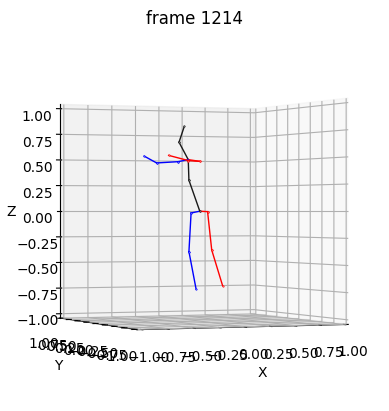

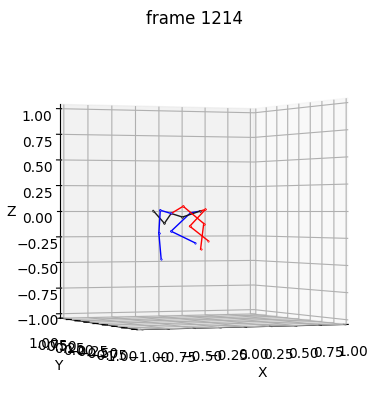

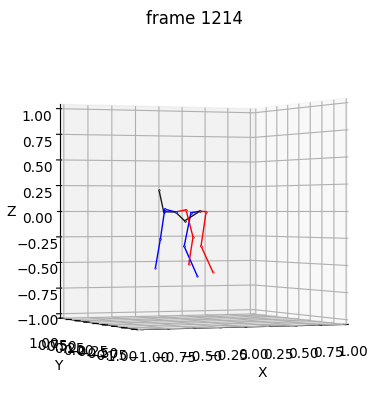

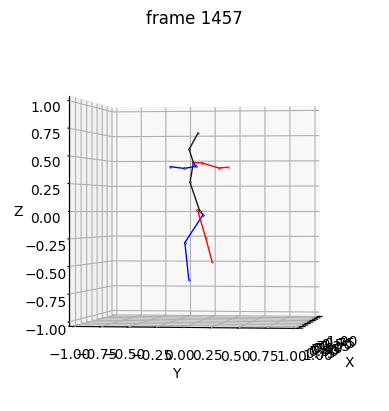

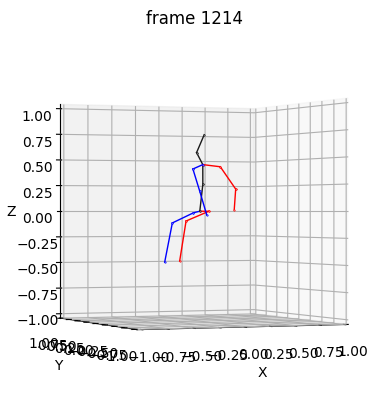

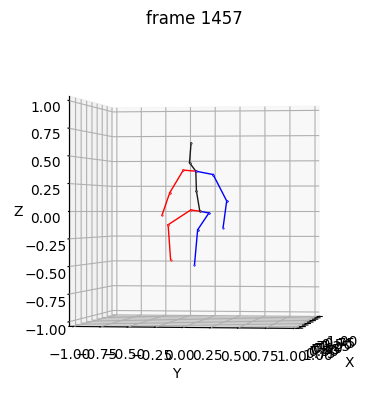

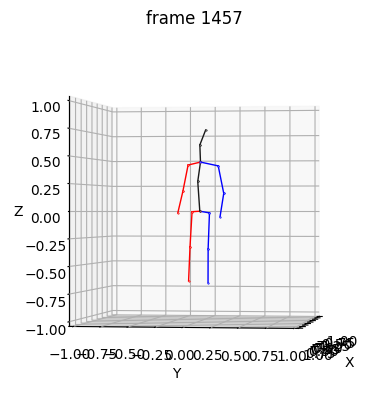

In [84]:
for target_model in ['FT_MB_ft_h36m_kookmin_total_with_kookmin_setting2_test1']:
    opts = parse_args(target=target_model)
    args = get_config(opts.config)
    #print(opts.evaluate)

    if 'DHDST2' in opts.evaluate: model_pos = DHDSTformer2(chk_filename='', args=args)
    elif 'DHDST_torso' in opts.evaluate: model_pos = DHDSTformer_torso(chk_filename='', args=args)
    elif 'DHDST_limb' in opts.evaluate: model_pos = DHDSTformer_limb(chk_filename='', args=args)
    elif 'MB' in opts.evaluate: model_pos = load_backbone(args)
        
    model_pos = nn.DataParallel(model_pos)
    model_pos = model_pos.cuda()
    checkpoint = torch.load(opts.evaluate, map_location=lambda storage, loc: storage)
    model_pos.load_state_dict(checkpoint['model_pos'], strict=True)
    model_pos = model_pos.eval()
    
    for target in target_list:
        subject, action, cam_id = target
        W = 1080
        H = 1920
        target_video = f'kookmin2_{subject}_{action}_{cam_id}'
        data = readJSON(f'/home/hrai/codes/mmpose/work_dirs/mmpose_result_for_action_recognition/{subject}_{action}_{cam_id}.json')
        #frames = get_video_frame_kookmin(subject, action, cam_id)
        
        pose_2d_list = []
        for frame_num in range(len(data['instance_info'])):
            max_score = 0
            max_idx = -1
            for i in range(len(data['instance_info'][frame_num]['instances'])):
                #print(np.mean(mmpose_result['instance_info'][frame_num]['instances'][i]['keypoint_scores']))
                if np.mean(data['instance_info'][frame_num]['instances'][i]['keypoint_scores']) > max_score:
                    max_score = np.mean(data['instance_info'][frame_num]['instances'][i]['keypoint_scores'])
                    max_idx = i
            keypoint = np.array(data['instance_info'][frame_num]['instances'][max_idx]['keypoints'])
            pose_2d_list.append(keypoint)
        pose_2d_list = np.array(pose_2d_list)
        pose_2d_list = np.append(pose_2d_list, np.ones((pose_2d_list.shape[0], pose_2d_list.shape[1], 1)), axis=2) # [:243]
        
        # inference
        if len(pose_2d_list) > 243:
            outputs = []
            input_datas = []
            for i in range(len(pose_2d_list)//243):
                start_frame = i*243
                if start_frame + 243 > len(pose_2d_list): break
                output, input_data, video_name = inference(args, 
                                                    model_pos, 
                                                    target_model, target_video,
                                                    pose_2d_list, 
                                                    W=W, H=H, 
                                                    start_frame=start_frame, clip_len=243, 
                                                    input_type='video', 
                                                    canonical_input=False, 
                                                    visualize_input=False)
                outputs.append(output)
                input_datas.append(input_data)
            output = np.concatenate(outputs, axis=0)
            input_data = torch.cat(input_datas, axis=1)  
        else:
            output, input_data, video_name = inference(args, 
                                                    model_pos, 
                                                    target_model, target_video,
                                                    pose_2d_list, 
                                                    W=W, H=H, 
                                                    start_frame=0, clip_len=243, 
                                                    input_type='video', 
                                                    canonical_input=False, 
                                                    visualize_input=False)
        
        output = get_rootrel_pose(output)
        
        # save output video
        save_mb_output_video(output, input_data, target_video, video_name, 
                            xlim=(-1,1), ylim=(-1,1), zlim=(-1, 1), grid=False, fps=60, dynamic_view=True,
                            imgs=frames, on_ground=False, refine_tilt=False, pose_type='3d')
    

### Data Loading (random limb)

In [5]:
args.dt_file = 'random_limb_train1600_test400.pkl'
args.subset_list = ['RANDOM_LIMB_TRAIN1600_TEST400']
datareader = DataReaderRandomLimb(n_frames=args.clip_len, sample_stride=args.sample_stride, data_stride_train=args.data_stride, data_stride_test=args.clip_len, dt_root = 'data/motion3d', dt_file=args.dt_file)
testloader_params = {
        'batch_size': args.batch_size,
        'shuffle': False,
        'num_workers': 12,
        'pin_memory': True,
        'prefetch_factor': 4,
        'persistent_workers': True
}
test_dataset = MotionDataset3D(args, args.subset_list, 'test')
test_loader = DataLoader(test_dataset, **testloader_params)


In [8]:
loss = 0
with torch.no_grad():
    for batch_input, batch_gt in tqdm(test_loader):
        if torch.cuda.is_available():
            batch_input = batch_input.cuda()
            batch_gt = batch_gt.cuda()
        batch_output = model_pos(batch_input)
        # if 'DHDST2' in opts.evaluate:
        #     batch_output = model_pos(batch_input)
        # elif 'DHDST_torso' in opts.evaluate:
        #     batch_torso_output, batch_lower_frame_R, batch_upper_frame_R  = model_pos(batch_input)
        # elif 'DHDSTformer_limb' in opts.evaluate:
        #     batch_output = model_pos(batch_input, batch_gt_torso)
        # elif 'MB' in opts.evaluate:
        #     batch_output = model_pos(batch_input)
        break

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]


(3, 3)
(3, 3)


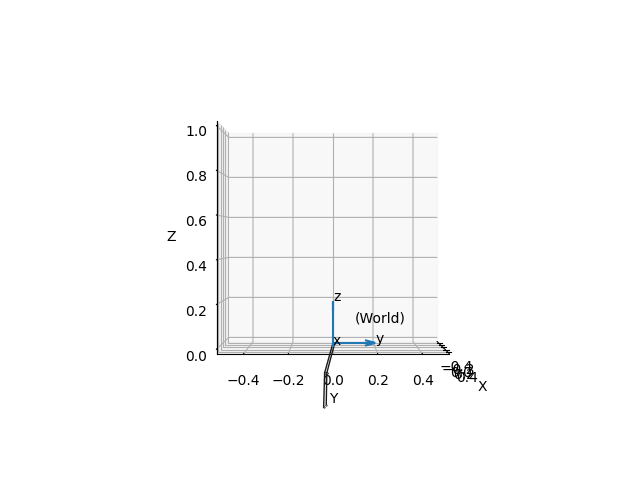

In [22]:
# check output (1 frame)
batch_num = 10
frame_num = 179

gt_pose = batch_gt[batch_num, frame_num].cpu().numpy()
pred_pose = batch_output[batch_num, frame_num].cpu().numpy()

def postprocessing(pose):
    #pose = get_rootrel_pose(output[0].copy()) # 1 frame
    print(pose.shape)
    R1 = Rotation.from_rotvec([-np.pi/2, 0, 0]).as_matrix() # -90 around x-axis
    R2 = Rotation.from_rotvec([0, 0, np.pi/2]).as_matrix() # 90 around z-axis
    pose = rotate_torso_by_R(pose, R2 @ R1)
    return pose

gt_pose = postprocessing(gt_pose)
pred_pose = postprocessing(pred_pose)
gt_pose_hat = gt_pose - gt_pose[0]

fig = plt.figure(5)
fig.clear()
ax = axes_3d(fig, xlim=(-0.5, 0.5), ylim=(-0.5, 0.5), zlim=(0, 1))
#draw_3d_pose(ax, gt_pose, dataset='limb')
draw_3d_pose(ax, gt_pose_hat, dataset='limb')
draw_3d_pose(ax, pred_pose, dataset='limb')
generate_world_frame().draw3d(scale=0.2, head_length=0.05)
plt.show()

### Results for kookmin squat (대각선 방향)

### Compare limb length result

In [ ]:
# _, split_id_test = datareader.get_split_id()
# actions = np.array(datareader.dt_dataset['test']['action']) # 103130 ['squat' ...  'kneeup']
# factors = np.array(datareader.dt_dataset['test']['2.5d_factor']) # 103130 [3.49990559 ... 2.09230852]
# gts = np.array(datareader.dt_dataset['test']['joints_2.5d_image']) # 103130, 17, 3
# sources = np.array(datareader.dt_dataset['test']['source']) # 103130 ['S02_6_squat_001' ... 'S08_4_kneeup_001']

# num_test_frames = len(actions)
# frames = np.array(range(num_test_frames))
# action_clips = np.array([actions[split_id_test[i]] for i in range(len(split_id_test))]) # actions[split_id_test]
# factor_clips = np.array([factors[split_id_test[i]] for i in range(len(split_id_test))]) # factors[split_id_test]
# source_clips = np.array([sources[split_id_test[i]] for i in range(len(split_id_test))]) # sources[split_id_test]
# frame_clips  = np.array([frames[split_id_test[i]] for i in range(len(split_id_test))]) # frames[split_id_test]
# gt_clips     = np.array([gts[split_id_test[i]] for i in range(len(split_id_test))]) # gts[split_id_test]

In [13]:
# split_id_test[idx], action_clips[idx], factor_clips[idx], source_clips[idx], frame_clips[idx], gt_clips[idx].shape

In [21]:
# for frame in range(0, len(gt_clips[idx]), 50):
#     print(factor_clips[idx][frame])
#     pose_3d_pred = results_all[idx][frame] * 3.7#factor_clips[idx][frame]
#     pose_3d_gt = gt_clips[idx][frame]
#     pose_3d_pred -= pose_3d_pred[0]
#     pose_3d_gt -= pose_3d_gt[0]
#     fig = plt.figure(0)
#     fig.clear()
#     ax = axes_3d(fig)
#     draw_3d_pose(ax, pose_3d_pred/1000.0)
#     draw_3d_pose(ax, pose_3d_gt/1000.0)
#     #plt.show()
#     plt.savefig('test{}.png'.format(frame))
#     #break
    

3.499905586242676
3.5017988681793213
3.500577449798584
3.495361566543579
3.4970390796661377


In [16]:
h36m_connections = [
    (0,1),   # pelvis - r_hip
    (0,4),   # pelvis - l_hip
    (0,7),   # pelvis - torso
    (1,2),   # r_hip - r_knee
    (2,3),   # r_knee - r_ankle
    (4,5),   # l_hip - l_knee
    (5,6),   # l_knee - l_ankle
    (7,8),   # torso - neck
    (8,9),   # neck - nose
    (9,10),  # nose - headtop
    (8,14),  # neck - r_shoulder
    (14,15), # r_shoulder - r_elbow
    (15,16), # r_elbow - r_wrist
    (8,11),  # neck - l_shoulder
    (11,12), # l_shoulder - l_elbow
    (12,13)  # l_elbow - l_wrist
]

def get_link_length(pose_3d, connections):
    # pelvis, r_hip, l_hip, torso, neck, l_shoulder, r_shoulder = 0, 1, 4, 7, 8, 11, 14
    # r_knee, r_ankle, l_knee, l_ankle = 2, 3, 5, 6
    # l_elbow, l_wrist, r_elbow, r_wrist = 12, 13, 15, 16
    link_length = []
    for connection in connections:
        link_length.append(np.linalg.norm(pose_3d[connection[0]] - pose_3d[connection[1]]))
    return np.array(link_length)

In [17]:
pred_length = get_link_length(pose_3d_pred/1000.0, h36m_connections)
gt_length = get_link_length(pose_3d_gt/1000.0, h36m_connections)
length_error = abs(pred_length - gt_length)
length_error

array([0.00151713, 0.00091767, 0.00902751, 0.00368509, 0.0105386 ,
       0.00772105, 0.00898564, 0.00418692, 0.00352909, 0.0039919 ,
       0.00549086, 0.00596831, 0.00891203, 0.00368655, 0.00549003,
       0.00898395])

In [18]:
length_error[11], length_error[12], length_error[14], length_error[15]

(0.005968314041597089,
 0.008912034118529921,
 0.005490033523852411,
 0.008983945570708363)

In [19]:
print('pelvis - r_hip '      , length_error[0])
print('pelvis - l_hip '      , length_error[1])
print('pelvis - torso '      , length_error[2])
print('r_hip - r_knee '      , length_error[3])
print('r_knee - r_ankle '    , length_error[4])
print('l_hip - l_knee '      , length_error[5])
print('l_knee - l_ankle '    , length_error[6])
print('torso - neck '        , length_error[7])
print('neck - nose '         , length_error[8])
print('nose - headtop '      , length_error[9])
print('neck - r_shoulder '   , length_error[10])
print('r_shoulder - r_elbow ', length_error[11])
print('r_elbow - r_wrist '   , length_error[12])
print('neck - l_shoulder '   , length_error[13])
print('l_shoulder - l_elbow ', length_error[14])
print('l_elbow - l_wrist '   , length_error[15])

pelvis - r_hip  0.0015171253286587888
pelvis - l_hip  0.0009176691975954915
pelvis - torso  0.009027514946196968
r_hip - r_knee  0.003685085087576201
r_knee - r_ankle  0.010538599036833796
l_hip - l_knee  0.007721046316983782
l_knee - l_ankle  0.00898563922610851
torso - neck  0.004186921202962324
neck - nose  0.0035290896721586196
nose - headtop  0.003991901696320882
neck - r_shoulder  0.005490856398907756
r_shoulder - r_elbow  0.005968314041597089
r_elbow - r_wrist  0.008912034118529921
neck - l_shoulder  0.0036865529627456983
l_shoulder - l_elbow  0.005490033523852411
l_elbow - l_wrist  0.008983945570708363


In [126]:
np.linalg.norm(pose_3d_pred - pose_3d_gt, axis=1)

array([  0.        ,   0.54780174,   8.5182328 ,  24.26664485,
         2.13372334,   7.7515586 ,  18.62067092,  13.36413424,
        12.90177693,  21.32981271,  22.10233935,  13.77372539,
        56.95500214, 103.25992455,  26.47536456,  90.22016789,
        95.31798023])